# Data Investigation - Trip Data

### Import Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
sns.set()

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data Data...' % datetime.datetime.now().time())
try:
    trip_data = pd.DataFrame()
    trip_data_file = '../FINAL/clean_data/trip_data_extended_cleaned.csv'

    # Chunk Settings
    chunks = []
    chunk_counter = 1
    chunksize = 10000
    num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

    # import file in chunks
    for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):

        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1
    
    trip_data = pd.concat(chunks)

    print('[%s] Complete!' % datetime.datetime.now().time())

except:
    print('oops... something went wrong importing the data :(')
    


[15:09:32.267138] Loading Trip Data Data...
		[15:09:33.565669] finished chunk 1 of 96
		[15:09:34.767520] finished chunk 10 of 96
		[15:09:36.132037] finished chunk 20 of 96
		[15:09:37.471729] finished chunk 30 of 96
		[15:09:38.828485] finished chunk 40 of 96
		[15:09:40.174247] finished chunk 50 of 96
		[15:09:41.532565] finished chunk 60 of 96
		[15:09:42.875906] finished chunk 70 of 96
		[15:09:44.245800] finished chunk 80 of 96
		[15:09:45.689923] finished chunk 90 of 96
		[15:09:46.379318] finished chunk 96 of 96
[15:09:47.232204] Complete!


In [4]:
trip_data.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,date,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [5]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955557 entries, 0 to 955556
Data columns (total 26 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null object
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
start_area            955557 non-null object
start_zip             955557 non-null int64
end_area              955557 non-null object
end_zip               955557 non-null int64
date                  955557 non-null object
max_temp              955507 non-null float64
mean_temp             955507 non-null float64
min_temp              9

## Utility Functions

In [6]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

zip_lookup = {
    94107 : 'San Francisco',
    94063 : 'Redwood City',
    94301 : 'Palo Alto',
    94041 : 'Mountain View',
    95113 : 'San Jose'
}

# Goal 1 - Identify Key User Groups

- All Users
    - Customers
    - Subscribers

In [7]:
# Separate Customer Data and SUbscriber Data
customer_trip_data = trip_data[trip_data.user_type == 'Customer'].copy()
subscriber_trip_data = trip_data[trip_data.user_type == 'Subscriber'].copy()

print('Desription\t\t\tTrip Count\tShare')
print('Total Trips Records\t\t%s' % len(trip_data))
print('Total Subscriber Trip Records\t%s\t\t%0.2f' % (len(subscriber_trip_data), len(subscriber_trip_data)/len(trip_data)*100.))
print('Total Customer Trip Records\t%s\t\t%0.2f' % (len(customer_trip_data), len(customer_trip_data)/len(trip_data)*100.))


Desription			Trip Count	Share
Total Trips Records		955557
Total Subscriber Trip Records	844570		88.39
Total Customer Trip Records	110987		11.61


# Goal 2 - Identify Usage Patterns for User Groups

> We have two key user groups, what are the similarities and difference of their ussage?
- Subscribers
    - Hour of the Day - Two Distinct peaks, during commute hours
    - Day of the Week - Weekday Trips out number Weekend Trips nearly 5 to 1
    - Month of the Year - Rougly 35% dip in November into December, remainder of year steady
- Customers
    - Hour of the Day - Nice Even lump during daylight hours 8am-7pm
    - Day of the Week - Weekends are busiest, but not by much
    - Month of the Year - Peak in September, busiest in Summer months
    
> How do these groups compare by volume?
- Subscribers make up 88.39% of all Trips
    - 78% of all Subscriber trips are during commuting hours


### Distribution by User Type

In [8]:
x_ticks = sorted(pd.unique(trip_data.start_date.dt.hour))
subscriber_y = trip_data[trip_data.user_type == 'Subscriber'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()
customer_y   = trip_data[trip_data.user_type == 'Customer'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()

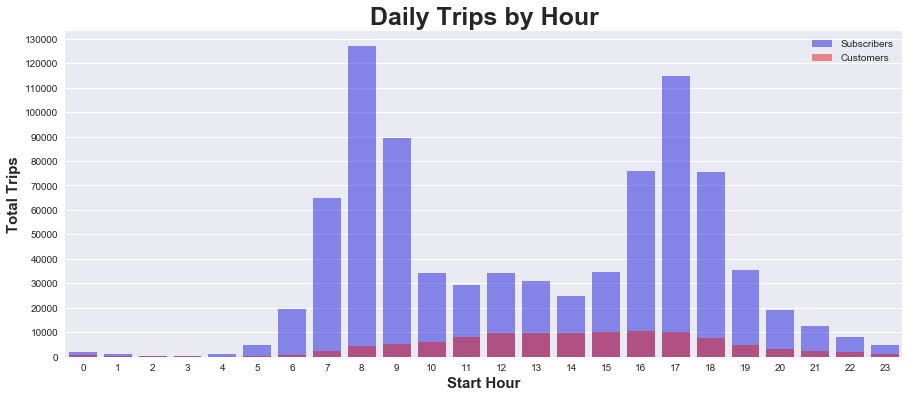

In [9]:
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = subscriber_y, color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = customer_y, color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Daily Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)


y_step = 10000
y_max = int(math.ceil(subscriber_y.max() / y_step) * y_step) + y_step
y_ticks = range(0, subscriber_y.max()+y_step, y_step)
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_yticks(y_ticks)
ax.legend(['Subscribers', 'Customers'], loc=1)


fig = ax.get_figure()
save_file = '../Documents/charts/00_%s' % ('Distribution of Trips by Hour'.replace(' ', '_'))
fig.savefig(save_file)

plt.legend()
plt.show()

In [10]:
y_max = trip_data[trip_data.user_type == 'Subscriber'].groupby(trip_data.start_date.dt.hour)['trip_id'].count().max()
y_max = int(math.ceil(y_max / 100000) * 100000)
y_step = int(y_max / 10)
y_ticks = range(0, y_max, y_step)

In [11]:
def plot_trip_distributions(user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000):
    
    def draw_plot(user_type, x, y, title, x_label, y_label, x_tick_labels, y_step, draw_lines = []):

        plt.subplots(figsize=(15,6))
        ax = sns.barplot(x = x, 
                         y = y, 
                         color = color, 
                         alpha = 0.5, 
                         label=user_type)

        ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
        

        ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(x_tick_labels)

        y_max = int(math.ceil(y.max() / y_step) * y_step) + y_step
        y_ticks = range(0, y.max()+y_step, y_step)

        ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
        ax.set_yticks(y_ticks)

        if len(draw_lines) > 0 and user_type == 'Subscriber':
            for xc in draw_lines:
                ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
        else:
            for xc in draw_lines[2:]:
                ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
            
        fig = ax.get_figure()
        save_file = '../Documents/charts/01_%s_%s' % (user_type, title.replace(' ', '_').replace('_-_', '_').replace('__', '_'))
        fig.savefig(save_file)

        plt.legend()
        plt.show()
     
    # Draw Trips by Hour of Day
    
    # Only Weekdays
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.hour)), 
              y = trip_data[(trip_data.user_type == user_type) & (trip_data.start_date.dt.dayofweek <= 4)].groupby(trip_data.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour - Weekdays Only' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = h_step,
              draw_lines=[6.5, 10.5, 15.5, 19.5])
    
    
    # Only Weekends
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.hour)), 
              y = trip_data[(trip_data.user_type == user_type) & (trip_data.start_date.dt.dayofweek > 4)].groupby(trip_data.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour - Weekends Only' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = 1000)
    
    # all days
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.hour)), 
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.hour)['trip_id'].count(), 
              title = ' %s Daily Trips by Hour' % user_type.title(), 
              x_label = 'Hour', 
              y_label = 'Trip Count', 
              x_tick_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                               '21', '22', '23'],
              y_step = h_step)

    
    
    # Draw Trips by Day of Week
    weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU',
                  4:'FRI', 5:'SAT', 6:'SUN'}
    
    draw_plot(user_type=user_type,
              x = sorted(pd.unique(trip_data.start_date.dt.dayofweek)), 
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.dayofweek)['trip_id'].count(), 
              title = ' %s Weekly Trips by Day' % user_type.title(), 
              x_label = 'Day of Week', 
              y_label = 'Trip Count', 
              x_tick_labels = [weekday_map[d] for d in sorted(pd.unique(trip_data.start_date.dt.dayofweek))],
              y_step = d_step)

    # Draw Trips by Month of Year
    month_map = {1:'JAN', 2:'FEB', 3:'MAR', 4:'APR', 
                 5:'MAY', 6:'JUN', 7:'JUL', 8:'AUG', 
                 9:'SEP', 10:'OCT', 11:'NOV', 12:'DEC'}

    month_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    draw_plot(user_type=user_type,
              x = month_ticks,
              y = trip_data[trip_data.user_type == user_type].groupby(trip_data.start_date.dt.month)['trip_id'].count(), 
              title = ' %s Monthly Trips by Year' % user_type.title(), 
              x_label = 'Month', 
              y_label = 'Trip Count', 
              x_tick_labels = [month_map[d] for d in sorted(pd.unique(trip_data.start_date.dt.month))],
              y_step = m_step)

### Subscriber Distribution

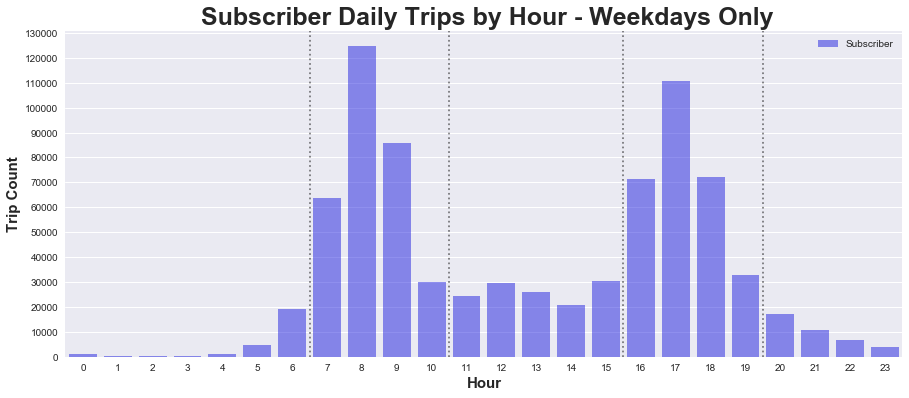

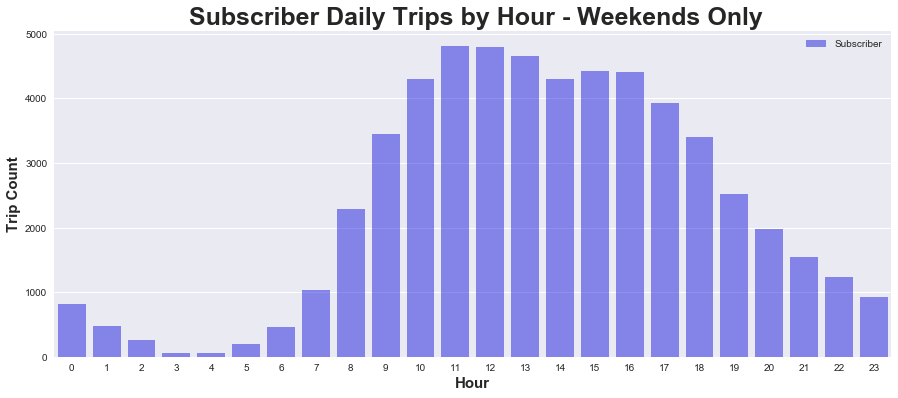

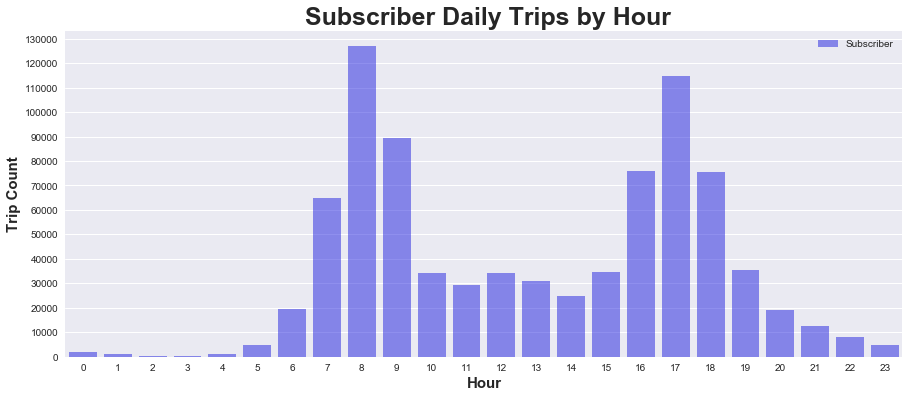

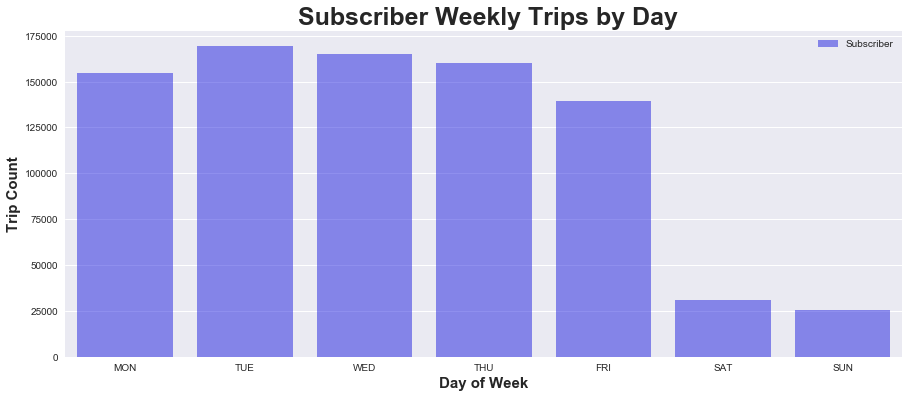

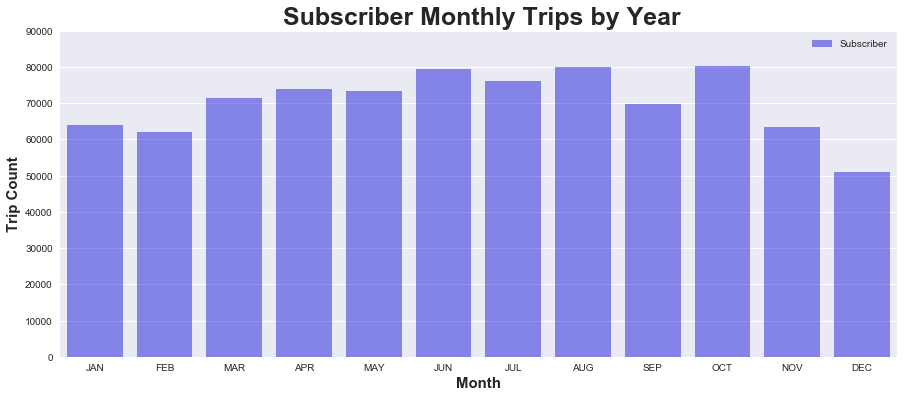

In [12]:
plot_trip_distributions(user_type = 'Subscriber', color='b', h_step=10000, d_step=25000, m_step=10000)

### Customer Distribution

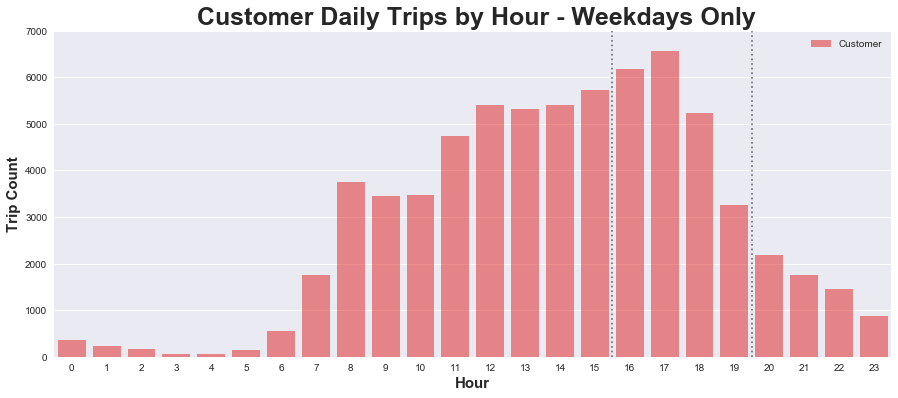

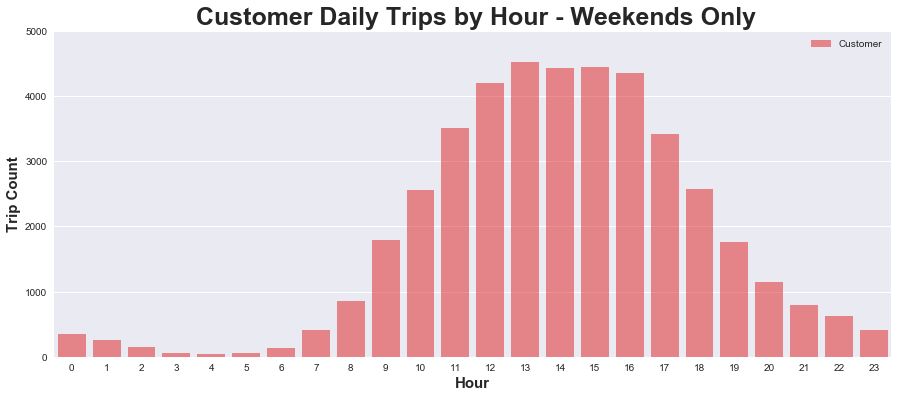

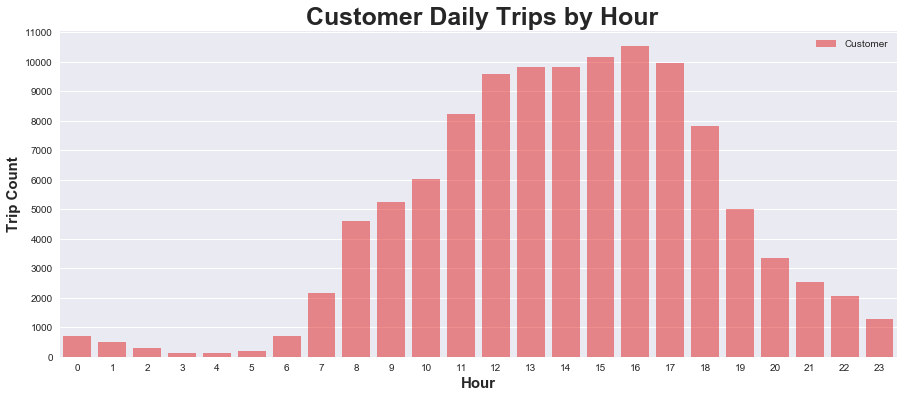

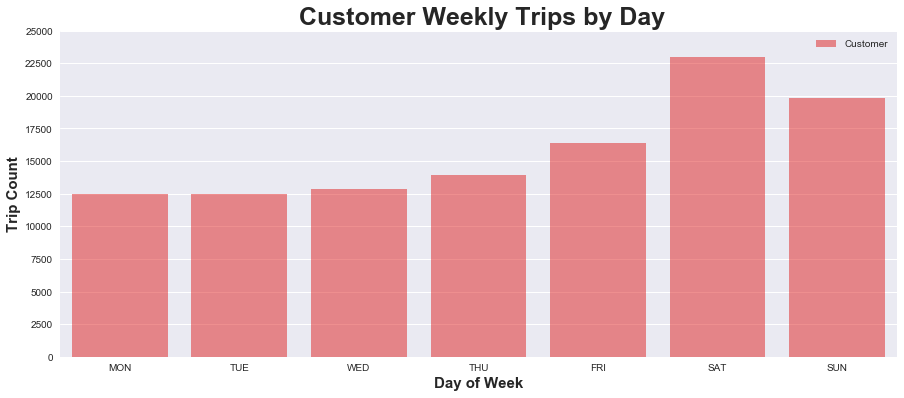

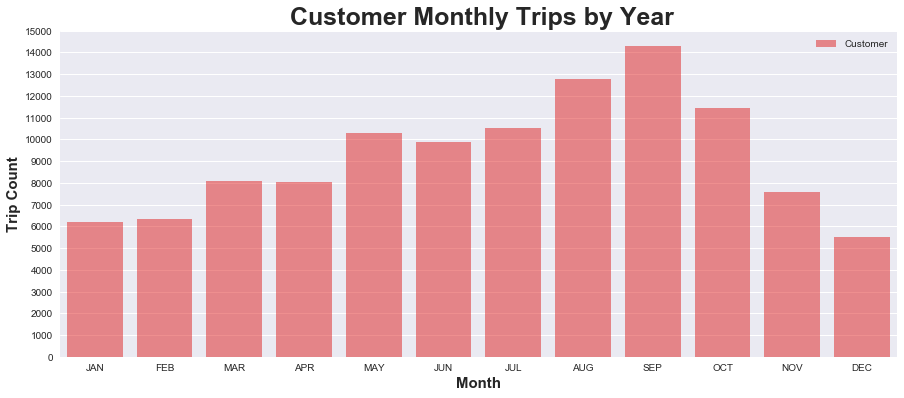

In [13]:
plot_trip_distributions(user_type = 'Customer', color='r', h_step=1000, d_step=2500, m_step=1000)

# Goal 3 - Identify Trends in Service Areas

> The Bay Area Bike Share Program serves 5 Metro Areas
- San Francisco
    - Identify Popular Terminals
    - Customers vs Subscribers
    
- San Jose
    - Identify Popular Terminals
    - Customers vs Subscribers

- Mountain View
    - Identify Popular Terminals
    - Customers vs Subscribers

- Palo Alto
    - Identify Popular Terminals
    - Customers vs Subscribers

- Redwood City
    - Identify Popular Terminals
    - Customers vs Subscribers

In [14]:
def plot_trip_heatmap(df, z=1, user_type='Subscriber', station_by='start', title_suffix=''):
    
    if user_type == 'Customer':
        cmap = sns.color_palette("OrRd", 10)
    elif user_type == 'Subscriber':
        cmap = sns.color_palette("PuBu", 10)
    else:
        cmap = sns.color_palette("YlGn", 10)
    
    if z < 5:
        data = df.copy()
    else:
        data = df[df.start_zip == z].copy()
        print('Total Trips in %s\t%s\t%0.2f' % (zip_lookup[z], len(data), (len(data)/len(df)) * 100.))

    if station_by == 'start':
        grid_set = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()

    elif station_by == 'end':
        grid_set = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()

    elif station_by == 'both':
        grid_set_A = data.groupby(['end_terminal', 'start_terminal'])['bike_id'].count().unstack()
        grid_set_B = data.groupby(['start_terminal', 'end_terminal'])['bike_id'].count().unstack()
        
        grid_set = grid_set_A + grid_set_B
        station_by = 'all'
        
    norm_grid     = grid_set/grid_set.max()

    plot_size=21

    fig1 = plt.subplots(figsize=(plot_size*1.5,plot_size))

    ax1 = sns.heatmap(grid_set, linewidths=.5, square=True, cbar=True, cmap=cmap, vmin=0, vmax=grid_set.max().max())
    sns.despine()
    if z < 5:
        title1 = '%s - %s Terminal Usage %s' % (user_type, station_by.title(), title_suffix.title())
        file1  = '%s - %s Terminal Usage Heatmap %s' % (user_type, station_by.title(), title_suffix.title())
    else:
        title1 = '%s - %s %s Terminal Usage %s' % (user_type, zip_lookup[z], station_by.title(), title_suffix.title())
        file1  = '%s - %s %s Terminal Usage Heatmap %s' % (user_type, zip_lookup[z], station_by.title(), title_suffix.title())
    
    if title_suffix != '':
        title1 = '%s %s Terminal Usage %s' % (zip_lookup[z], station_by.title(), title_suffix.title())
        file1  = '%s %s Terminal Usage Heatmap %s' % (zip_lookup[z], station_by.title(), title_suffix.title())
    
    title1 = title1.replace(' All ', ' ')
        
    ax1.set_title(title1, size=TITLE_FONT_SIZE*1.5*1.1, weight='bold')
    ax1.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax1.set_xticklabels(grid_set.columns, size=LABEL_FONT_SIZE*0.95*1.5)
    ax1.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95, weight='bold')
    ax1.set_yticklabels(grid_set.index, size=LABEL_FONT_SIZE*0.95*1.5, rotation=0)    
        
    plt.show()

    
    fig2 = plt.subplots(figsize=(plot_size*1.5,plot_size))

    ax2 = sns.heatmap(norm_grid, linewidths=.5, square=True, cbar=True, cmap=cmap, vmin=0, vmax=1)
    sns.despine()
    if z < 5:
        title2 = '%s - %s Terminal Usage %s' % (user_type, station_by.title(), title_suffix.title())
        file2  = '%s - %s Terminal Usage Heatmap %s' % (user_type, station_by.title(), title_suffix.title())
    else:
        title2 = '%s - %s %s Terminal Usage %s' % (user_type, zip_lookup[z], station_by.title(), title_suffix.title())
        file2  = '%s - %s %s Terminal Usage Heatmap %s' % (user_type, zip_lookup[z], station_by.title(), title_suffix.title())
    if title_suffix != '':
        title2 = '%s %s Terminal Usage %s' % (zip_lookup[z], station_by.title(), title_suffix.title())
        file2  = '%s %s Terminal Usage Heatmap %s' % (zip_lookup[z], station_by.title(), title_suffix.title())
    
    
    title2 = title2.replace(' All ', ' ')

    ax2.set_title(title2, size=TITLE_FONT_SIZE*1.5, weight='bold')
    ax2.set_xlabel('End Terminal', size=LABEL_FONT_SIZE*0.95*2.5, weight='bold')
    ax2.set_xticklabels(norm_grid.columns, size=LABEL_FONT_SIZE*0.95)
    ax2.set_ylabel('Start Terminal', size=LABEL_FONT_SIZE*0.95*2.5, weight='bold')
    ax2.set_yticklabels(norm_grid.index, size=LABEL_FONT_SIZE*0.95, rotation=0)
    
    try:
        if zip_lookup[z] != 'San Francisco' or zip_lookup[z] != 'San Jose':
            ax2.set_title(title2, size=TITLE_FONT_SIZE*1.5*1.1, weight='bold')
            ax2.set_xticklabels(norm_grid.columns, size=LABEL_FONT_SIZE*0.95*1.5)
            ax2.set_yticklabels(norm_grid.index, size=LABEL_FONT_SIZE*0.95*1.5, rotation=0)    
    except:
        pass
        
    fig2 = ax2.get_figure()
    save_file2 = '../Documents/charts/02_%s' % (file2.replace(' ', '_').replace('_-_', '_'))
    fig2.savefig(save_file2)
    plt.show()

In [15]:
def heatmap_regonalized_trips(df, user_type='Subscriber', title_suffix=''):
    
    terminal_usage = df[df.user_type == user_type].copy()

    # select only trips that start and end in same zip code
    regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip == terminal_usage.end_zip].copy()
    non_regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip != terminal_usage.end_zip].copy()

    print('Regional Terminal Usage\t\t', len(regonalized_terminal_usage))
    print('Non Regional Terminal Usage\t    %s\t\t%0.2f' % (len(non_regonalized_terminal_usage), (len(non_regonalized_terminal_usage)/ len(terminal_usage) * 100)))
    print('-' * 80)

    for z in sorted(pd.unique(df.start_zip)):
#         plot_trip_heatmap(regonalized_terminal_usage, z=z, user_type=user_type, station_by='start', title_suffix=title_suffix)
#         plot_trip_heatmap(regonalized_terminal_usage, z=z, user_type=user_type, station_by='end', title_suffix=title_suffix)
        plot_trip_heatmap(regonalized_terminal_usage, z=z, user_type=user_type, station_by='both', title_suffix=title_suffix)

        
        
def heatmap_usertype_trips(df, user_type='Subscriber', title_suffix=''):
    
    terminal_usage = df[df.user_type == user_type].copy()
        
    # select only trips that start and end in same zip code
    regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip == terminal_usage.end_zip].copy()
    non_regonalized_terminal_usage = terminal_usage[terminal_usage.start_zip != terminal_usage.end_zip].copy()

    print('Regional Terminal Usage\t\t', len(regonalized_terminal_usage))
    print('Non Regional Terminal Usage\t    %s\t\t%0.2f' % (len(non_regonalized_terminal_usage), (len(non_regonalized_terminal_usage)/ len(terminal_usage) * 100)))
    
#     plot_trip_heatmap(regonalized_terminal_usage, z=1, user_type=user_type, station_by='start', title_suffix=title_suffix)
#     plot_trip_heatmap(regonalized_terminal_usage, z=1, user_type=user_type, station_by='end', title_suffix=title_suffix)
    plot_trip_heatmap(regonalized_terminal_usage, z=1, user_type=user_type, station_by='both', title_suffix=title_suffix)

    

### Subscriber Terminal Usage

Regional Terminal Usage		 843880
Non Regional Terminal Usage	    690		0.08


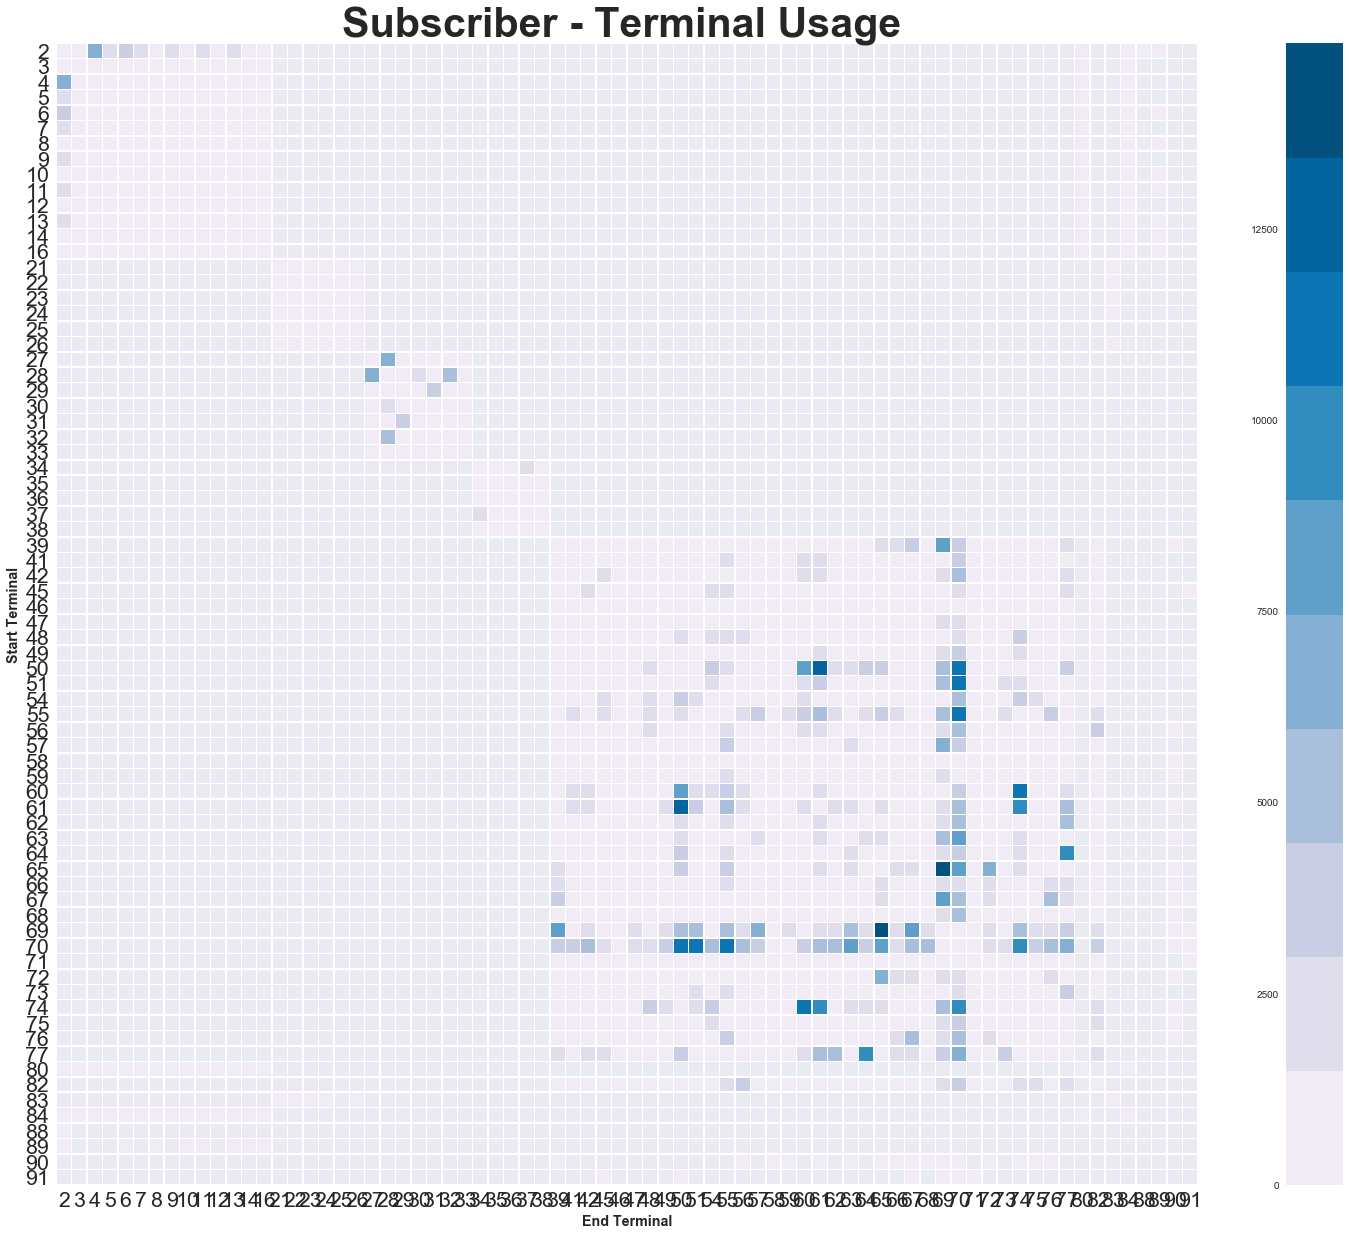

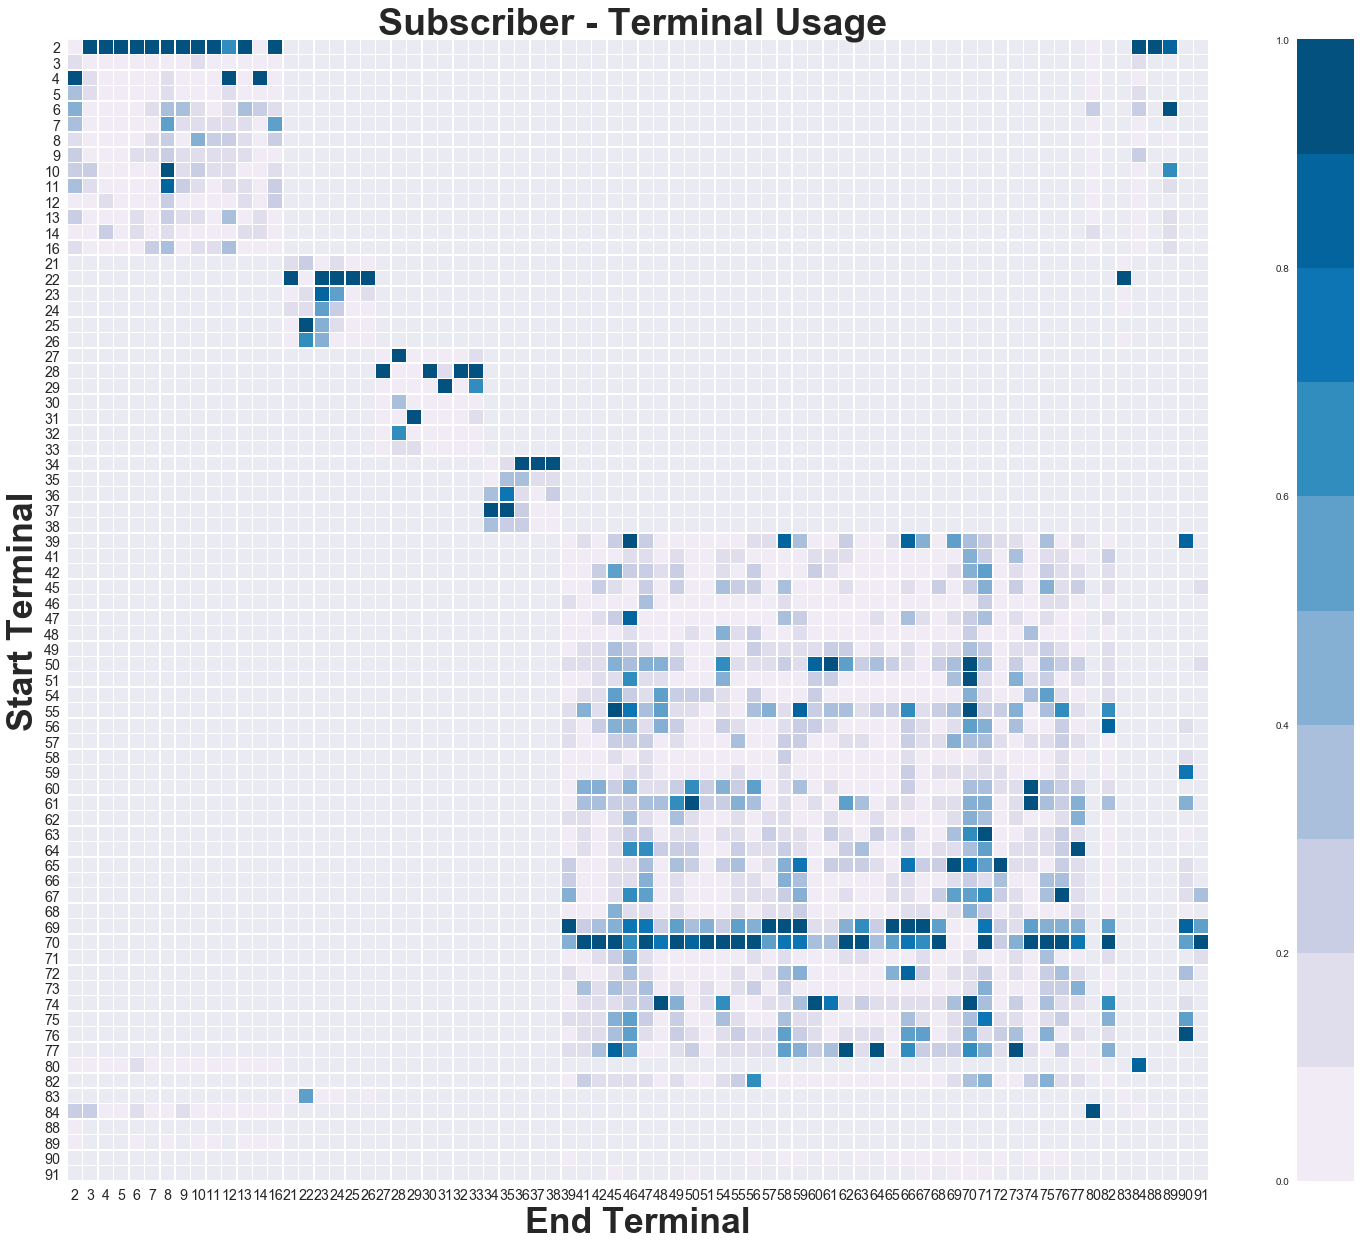

In [16]:
heatmap_usertype_trips(trip_data, user_type='Subscriber')

### Customer Terminal Usage

Regional Terminal Usage		 110524
Non Regional Terminal Usage	    463		0.42


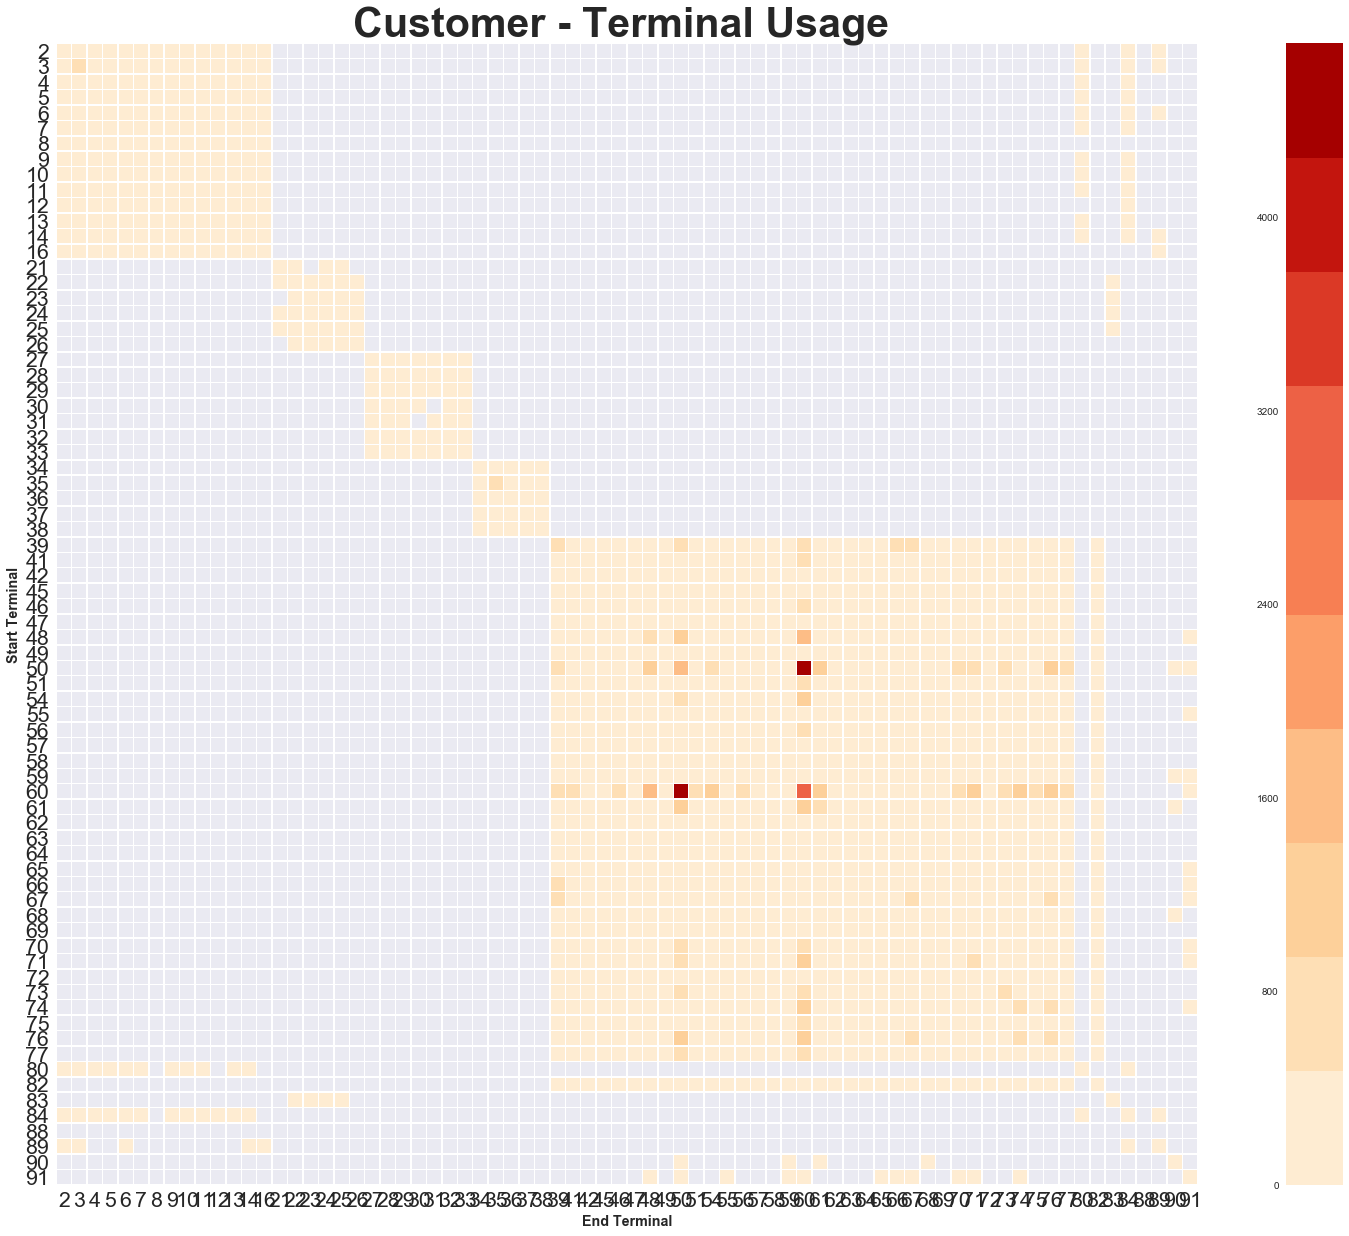

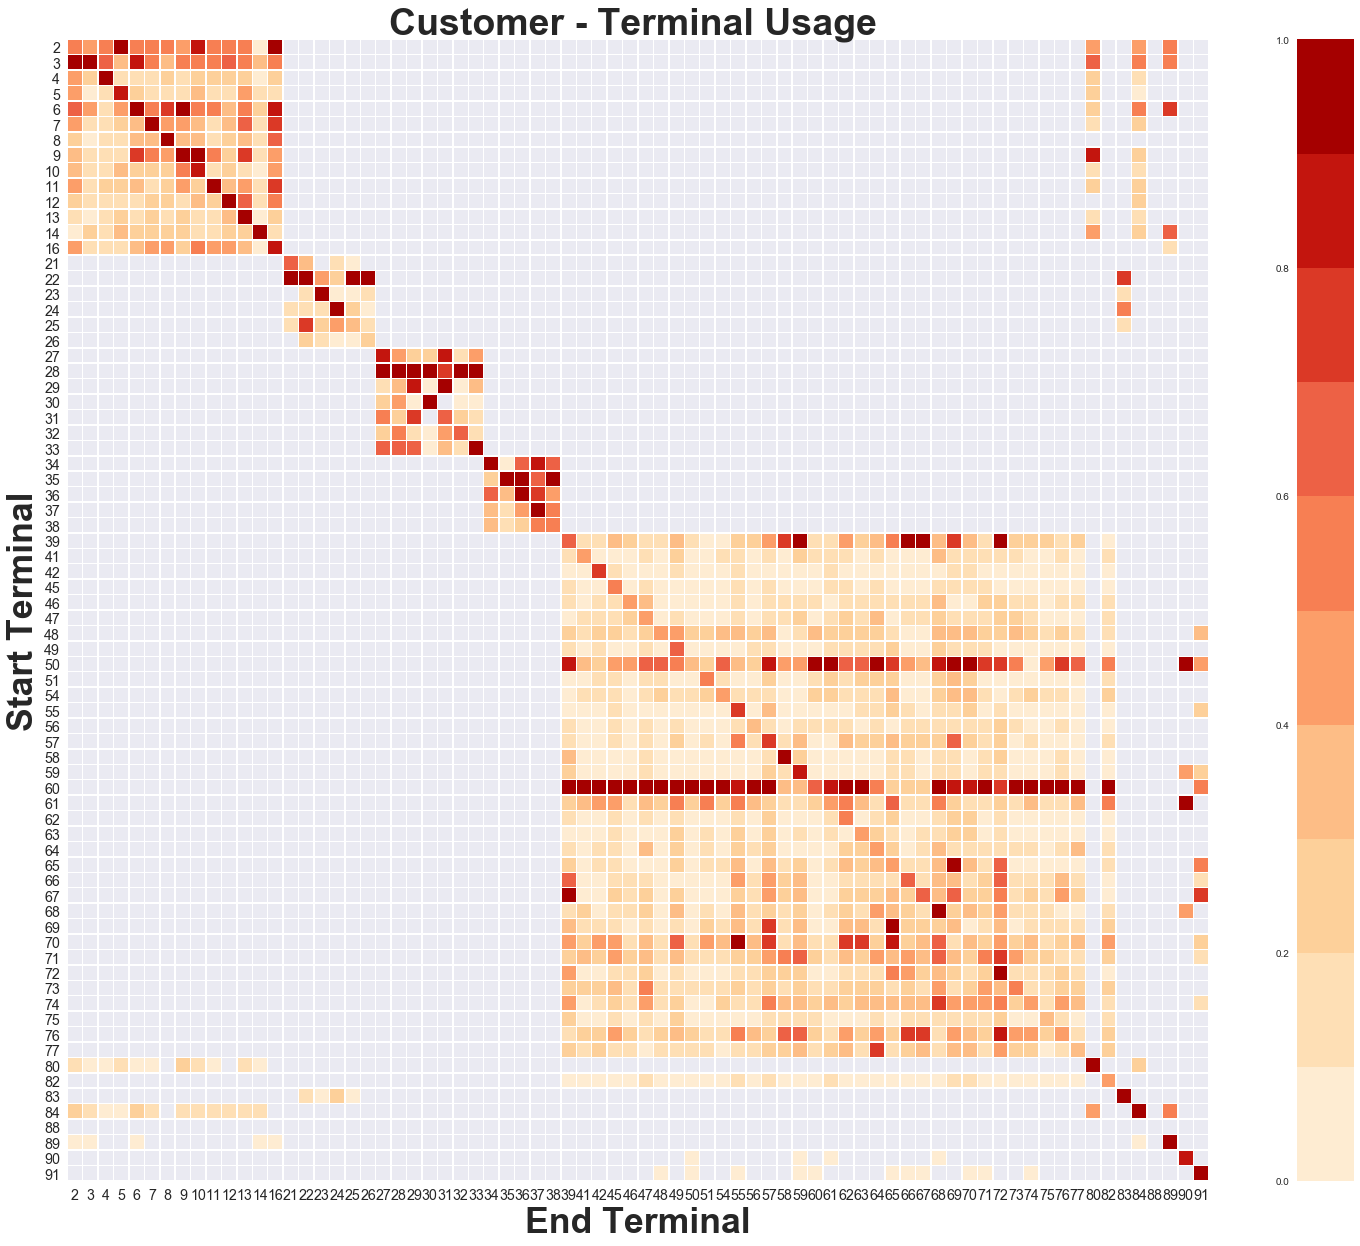

In [17]:
heatmap_usertype_trips(trip_data, user_type='Customer')

### Subscriber Terminal Usage - By Region

Regional Terminal Usage		 843880
Non Regional Terminal Usage	    690		0.08
--------------------------------------------------------------------------------
Total Trips in Mountain View	20620	2.44


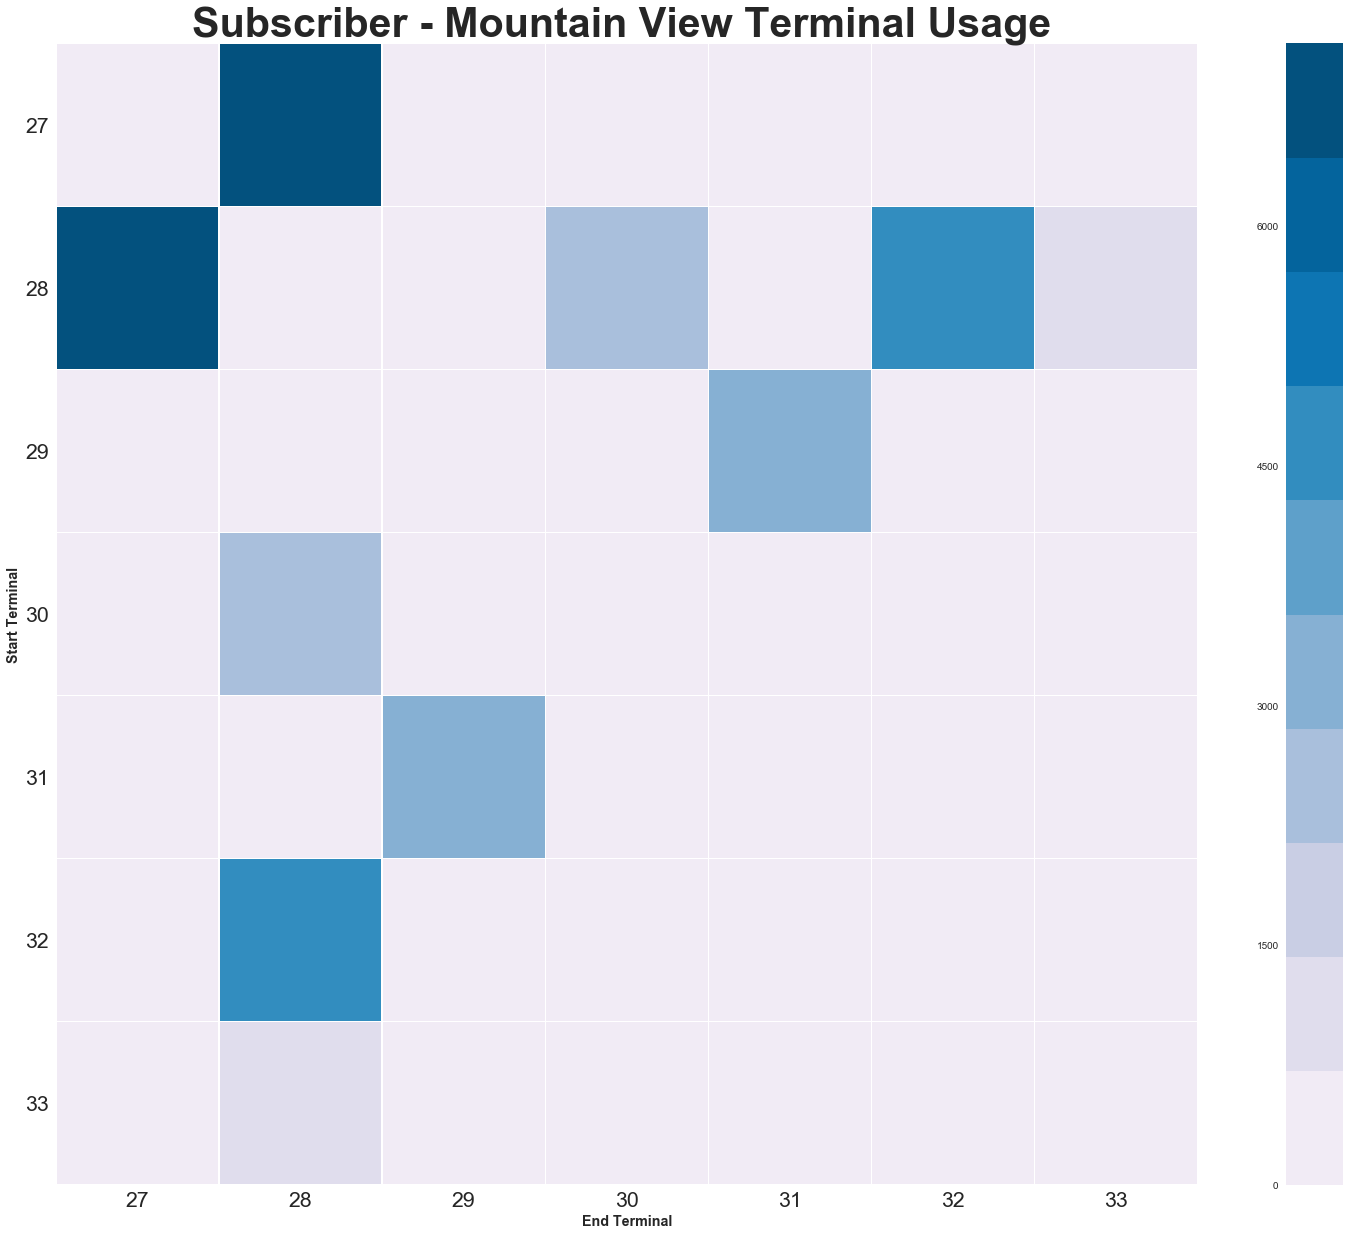

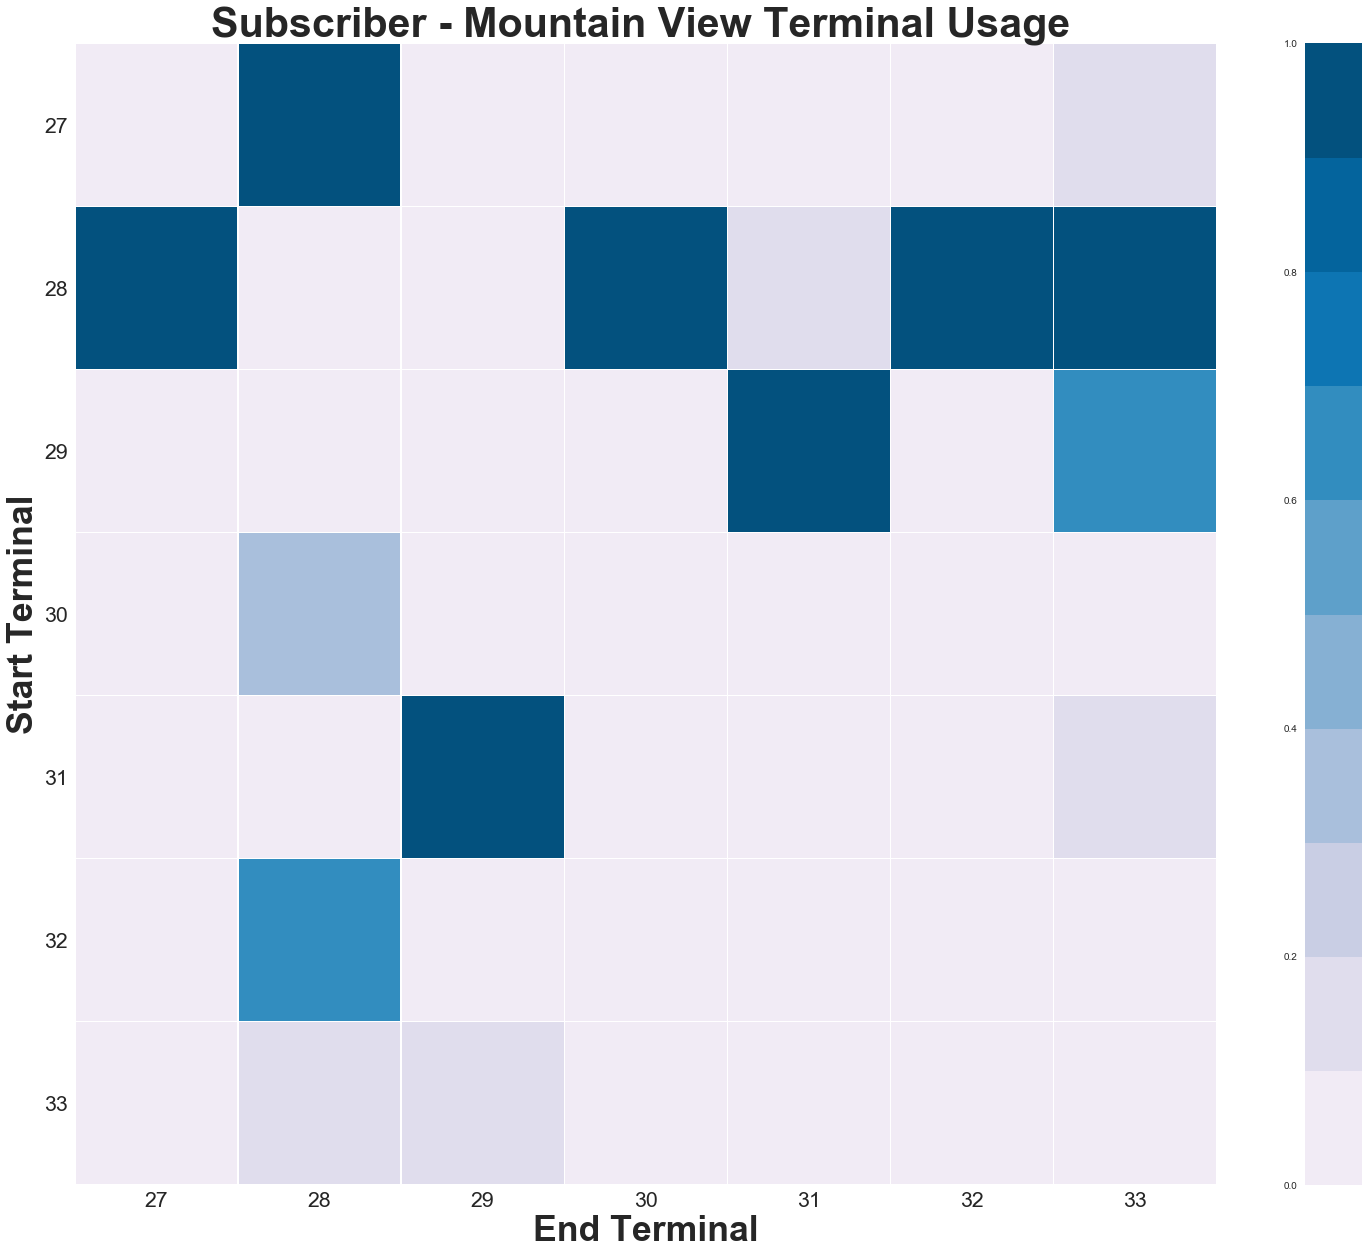

Total Trips in Redwood City	4075	0.48


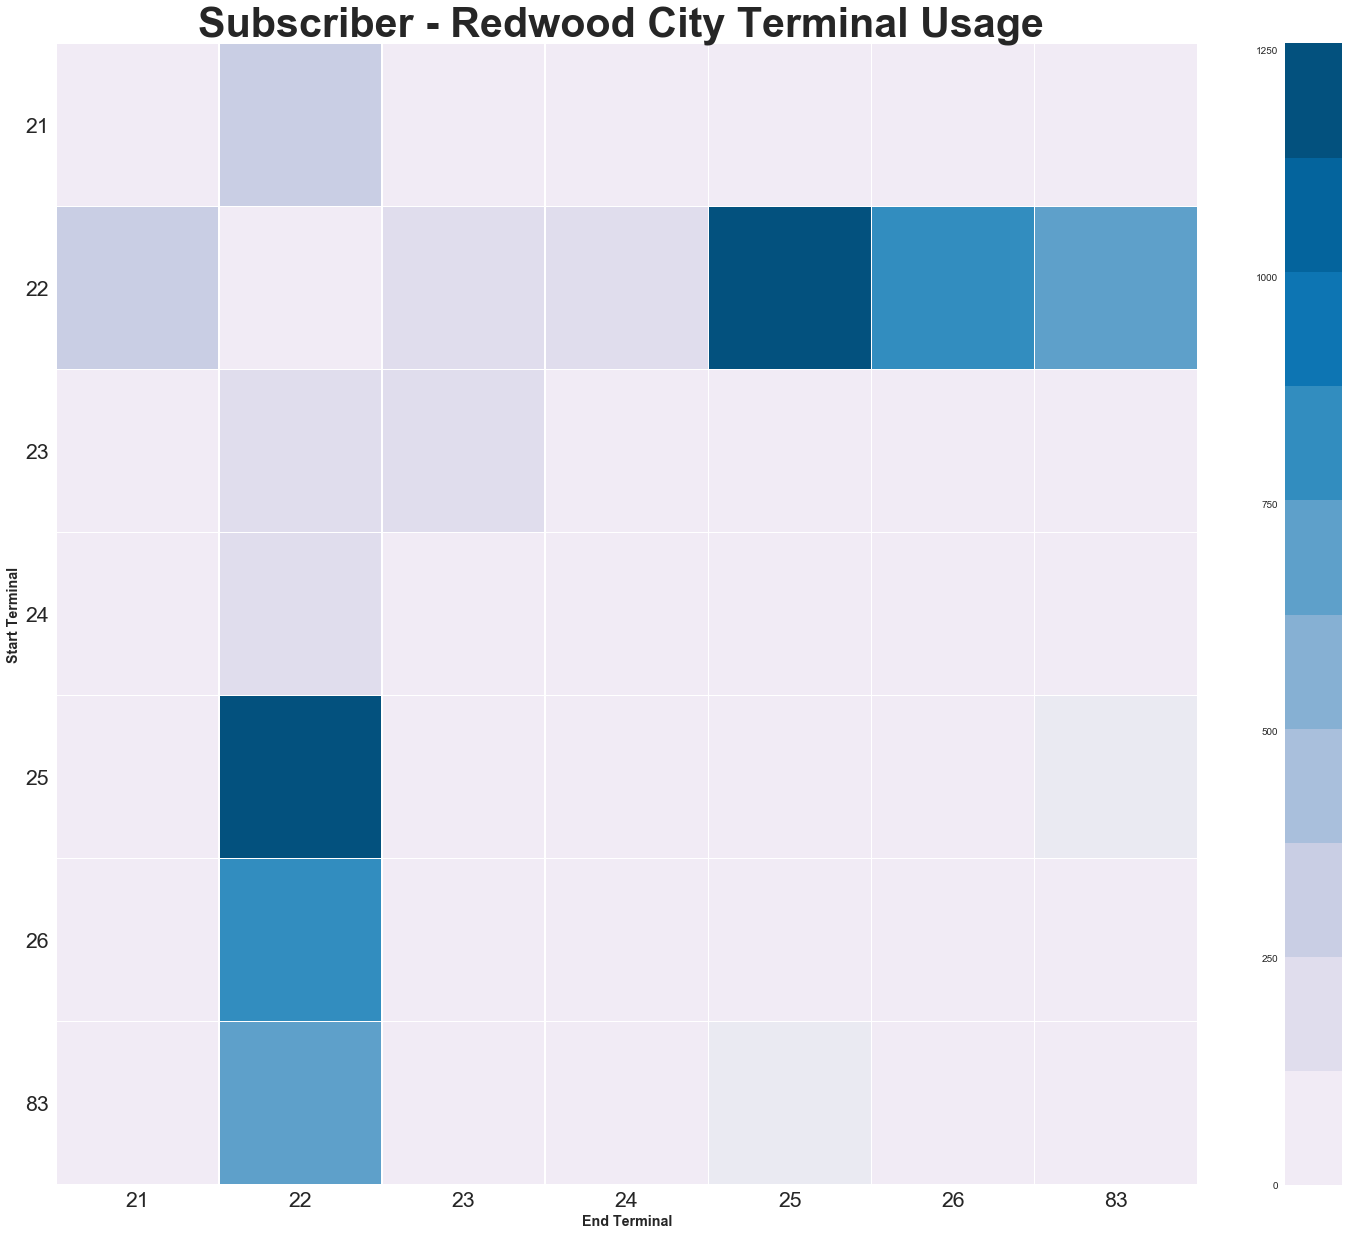

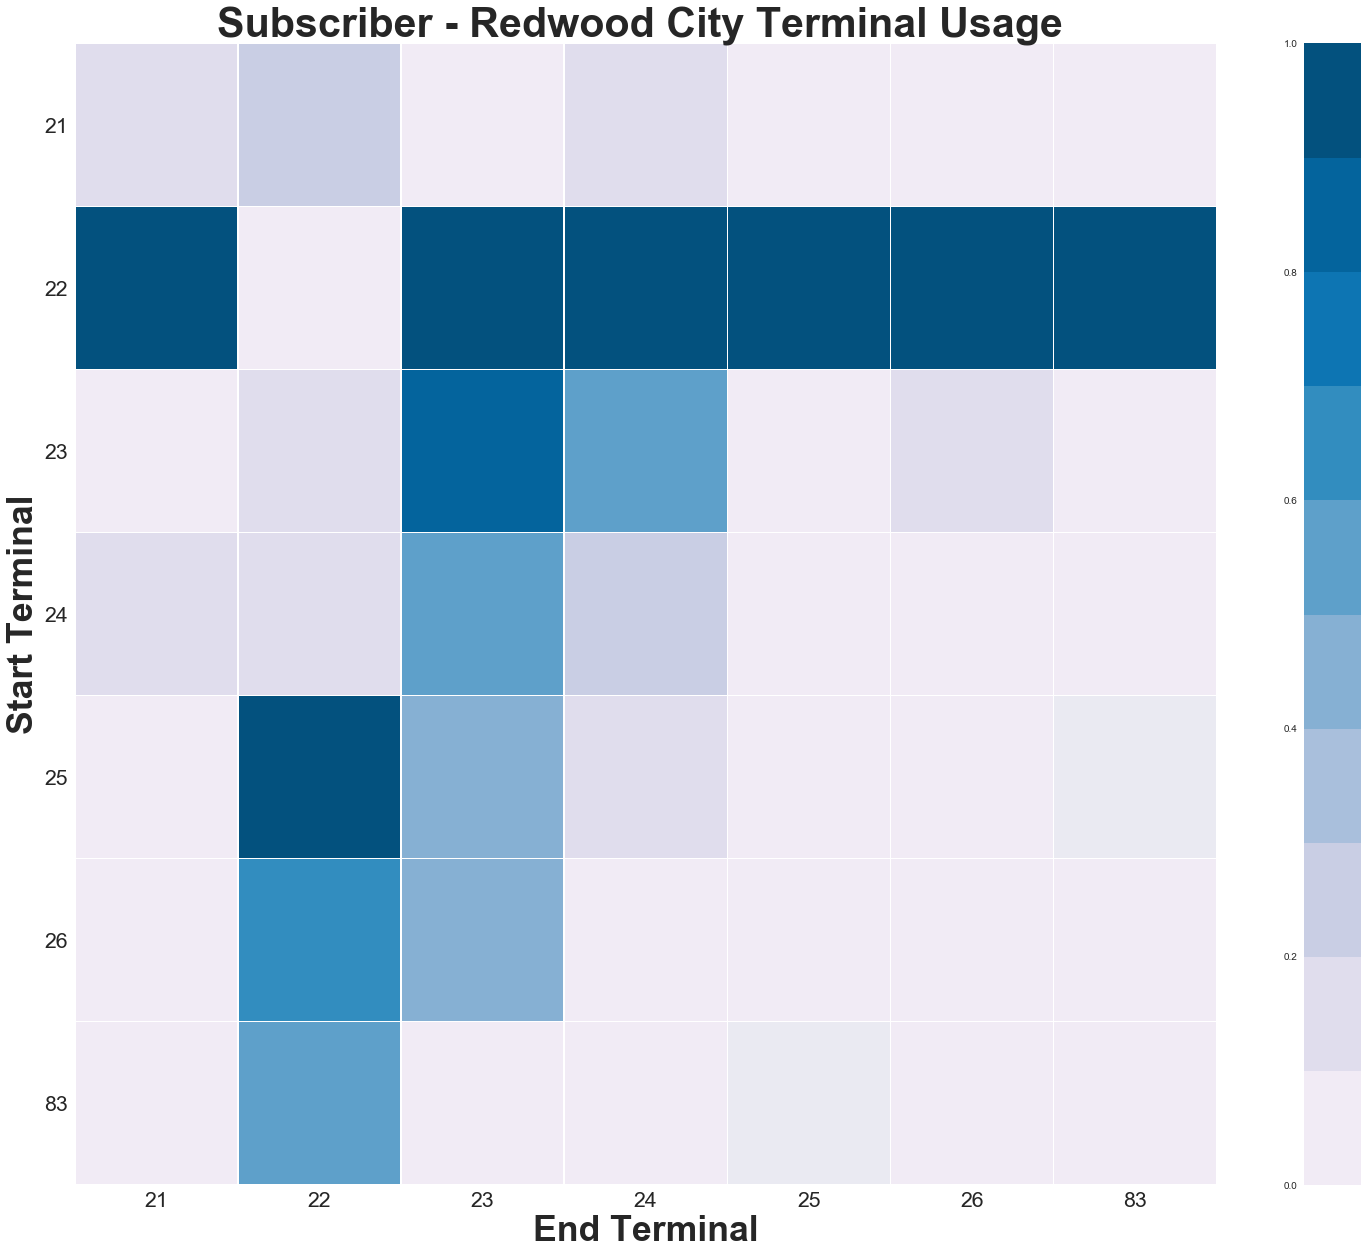

Total Trips in San Francisco	769677	91.21


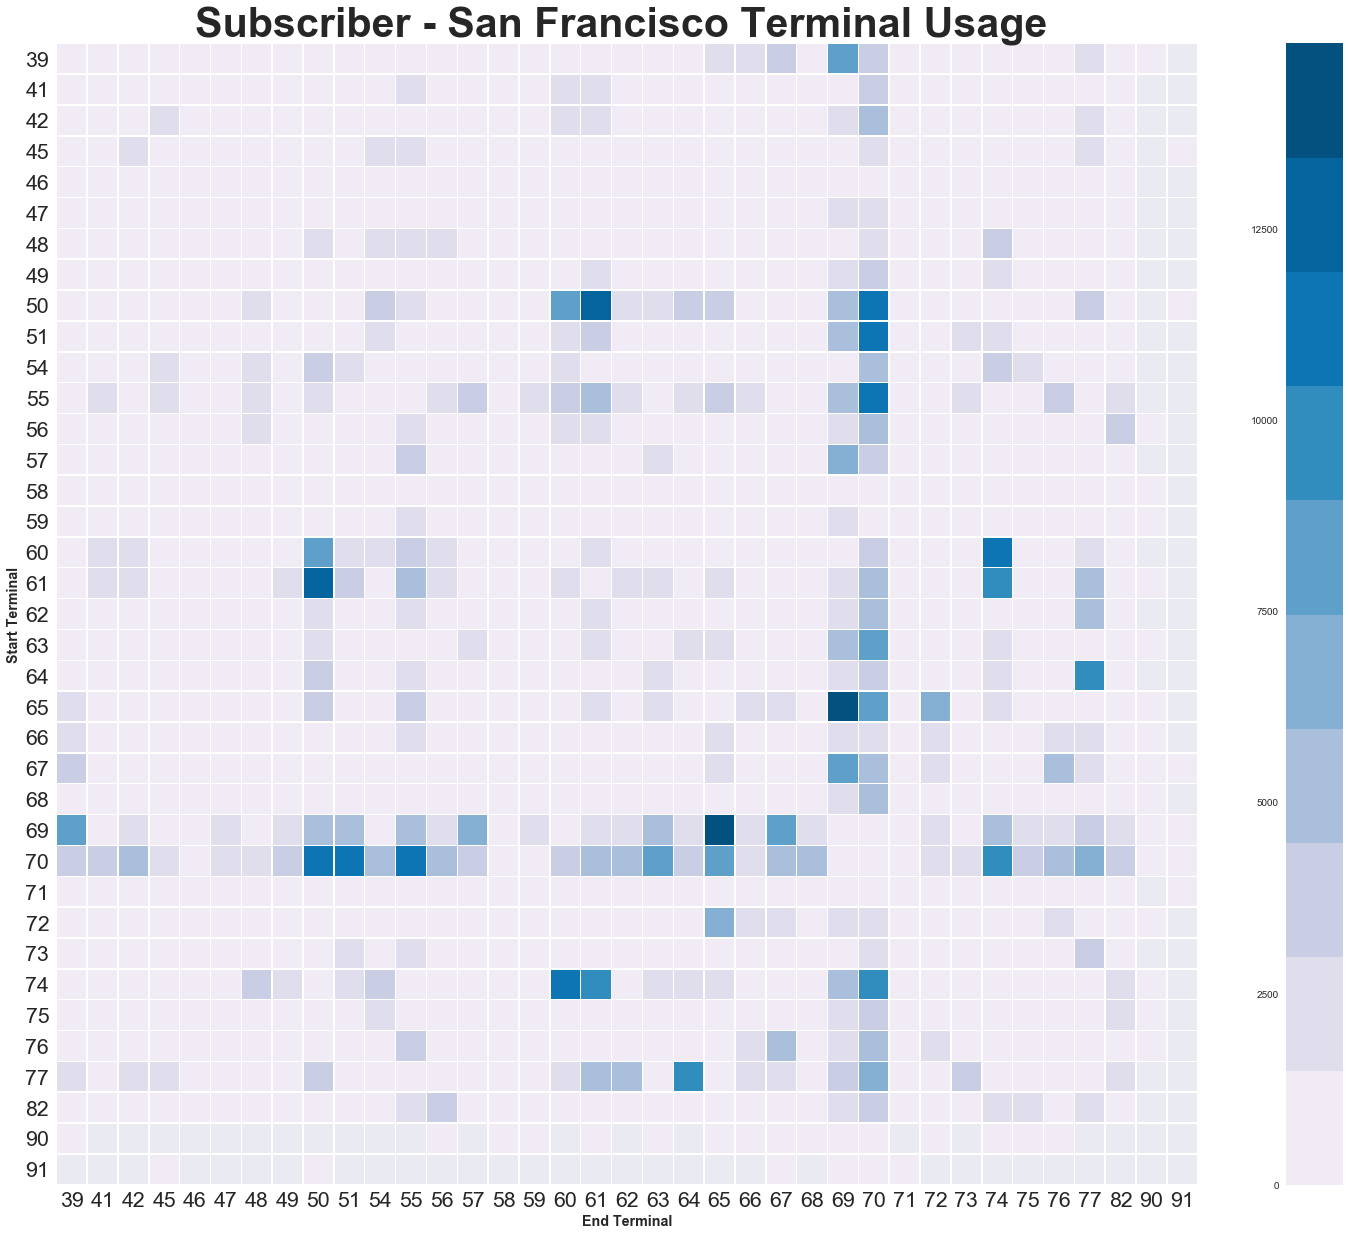

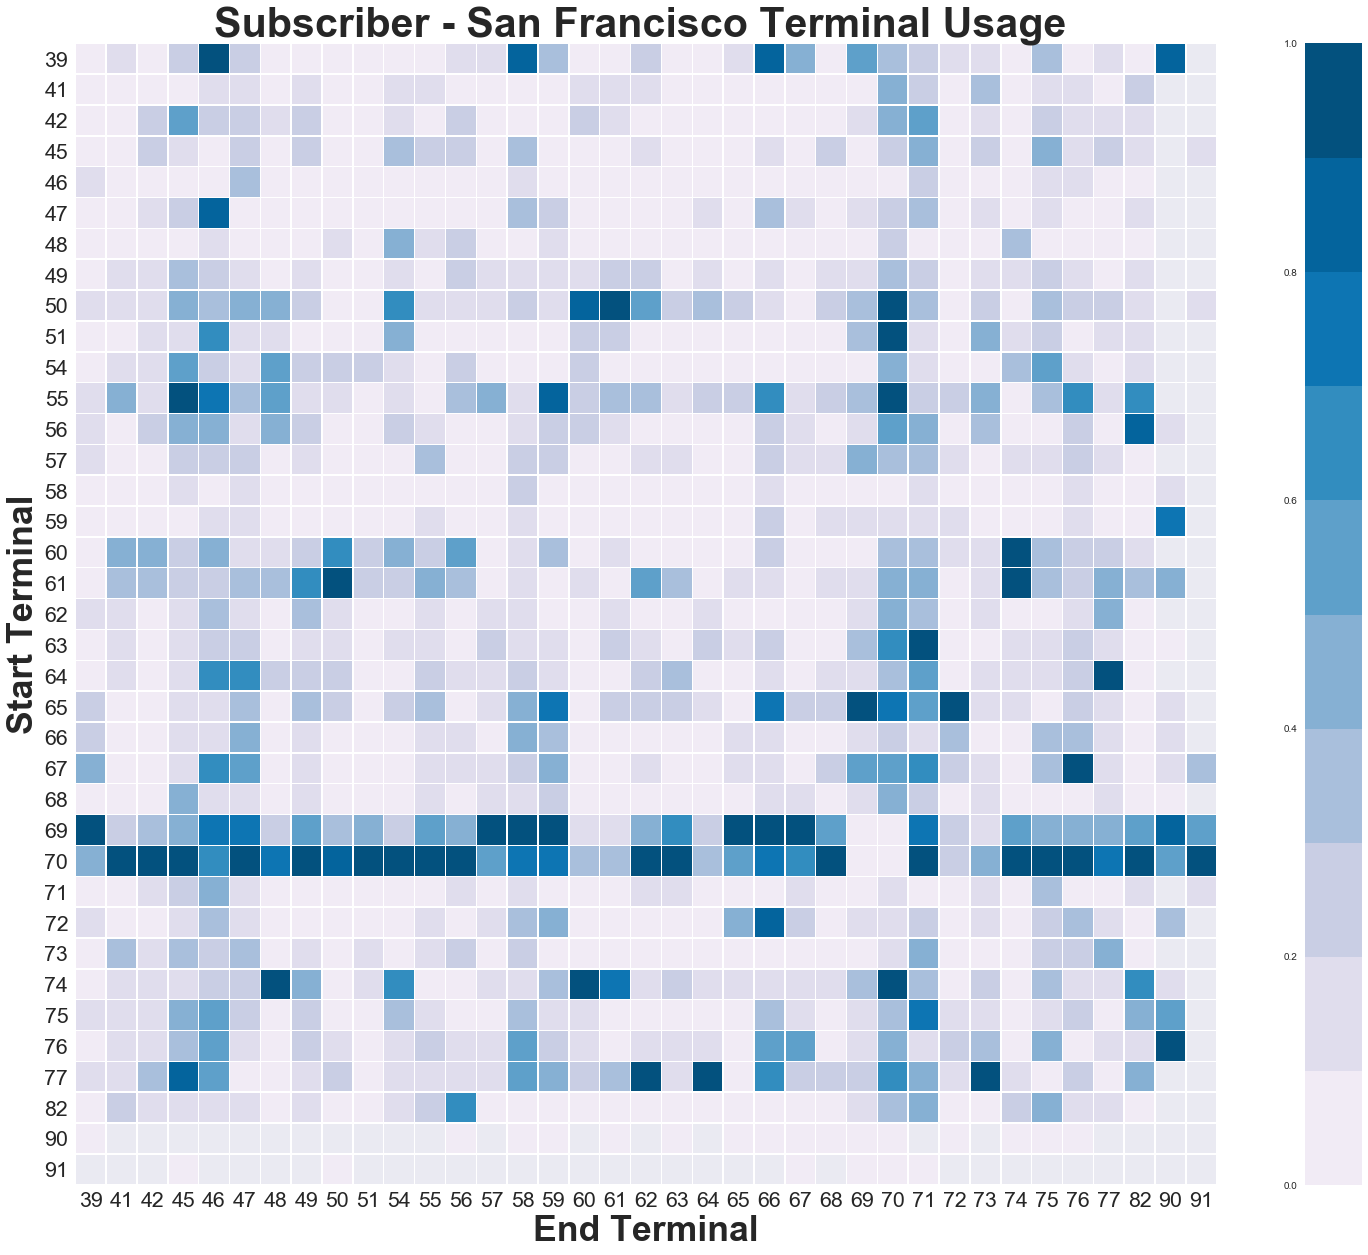

Total Trips in Palo Alto	5530	0.66


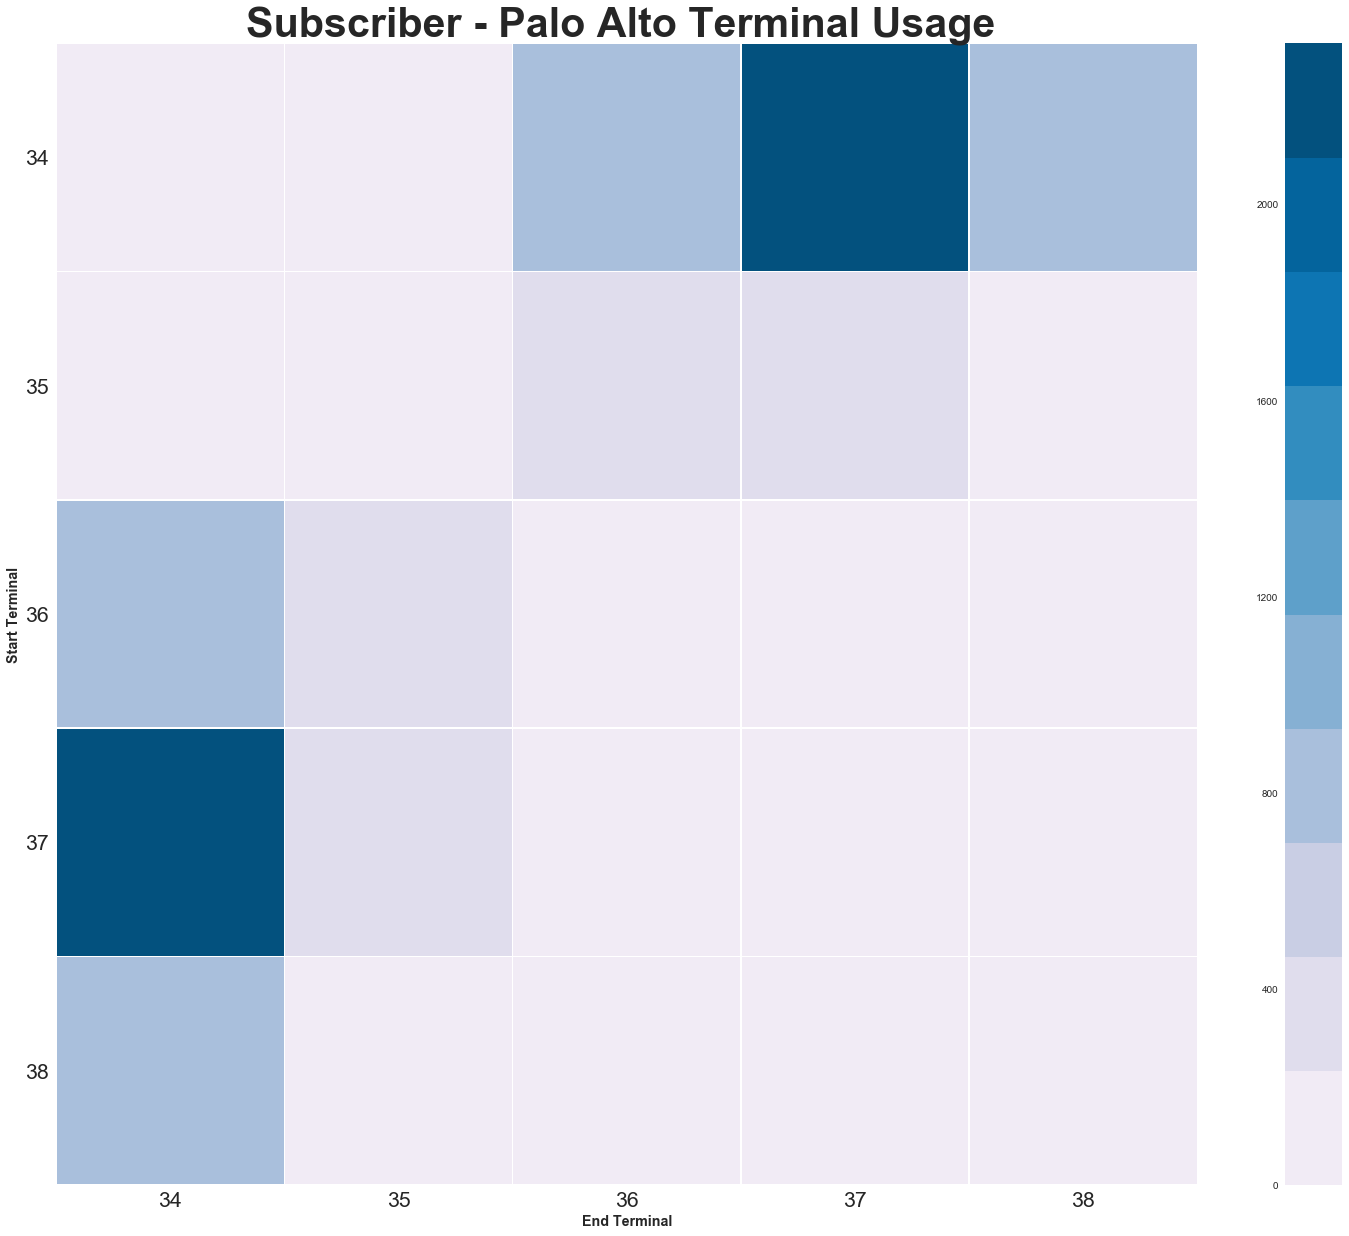

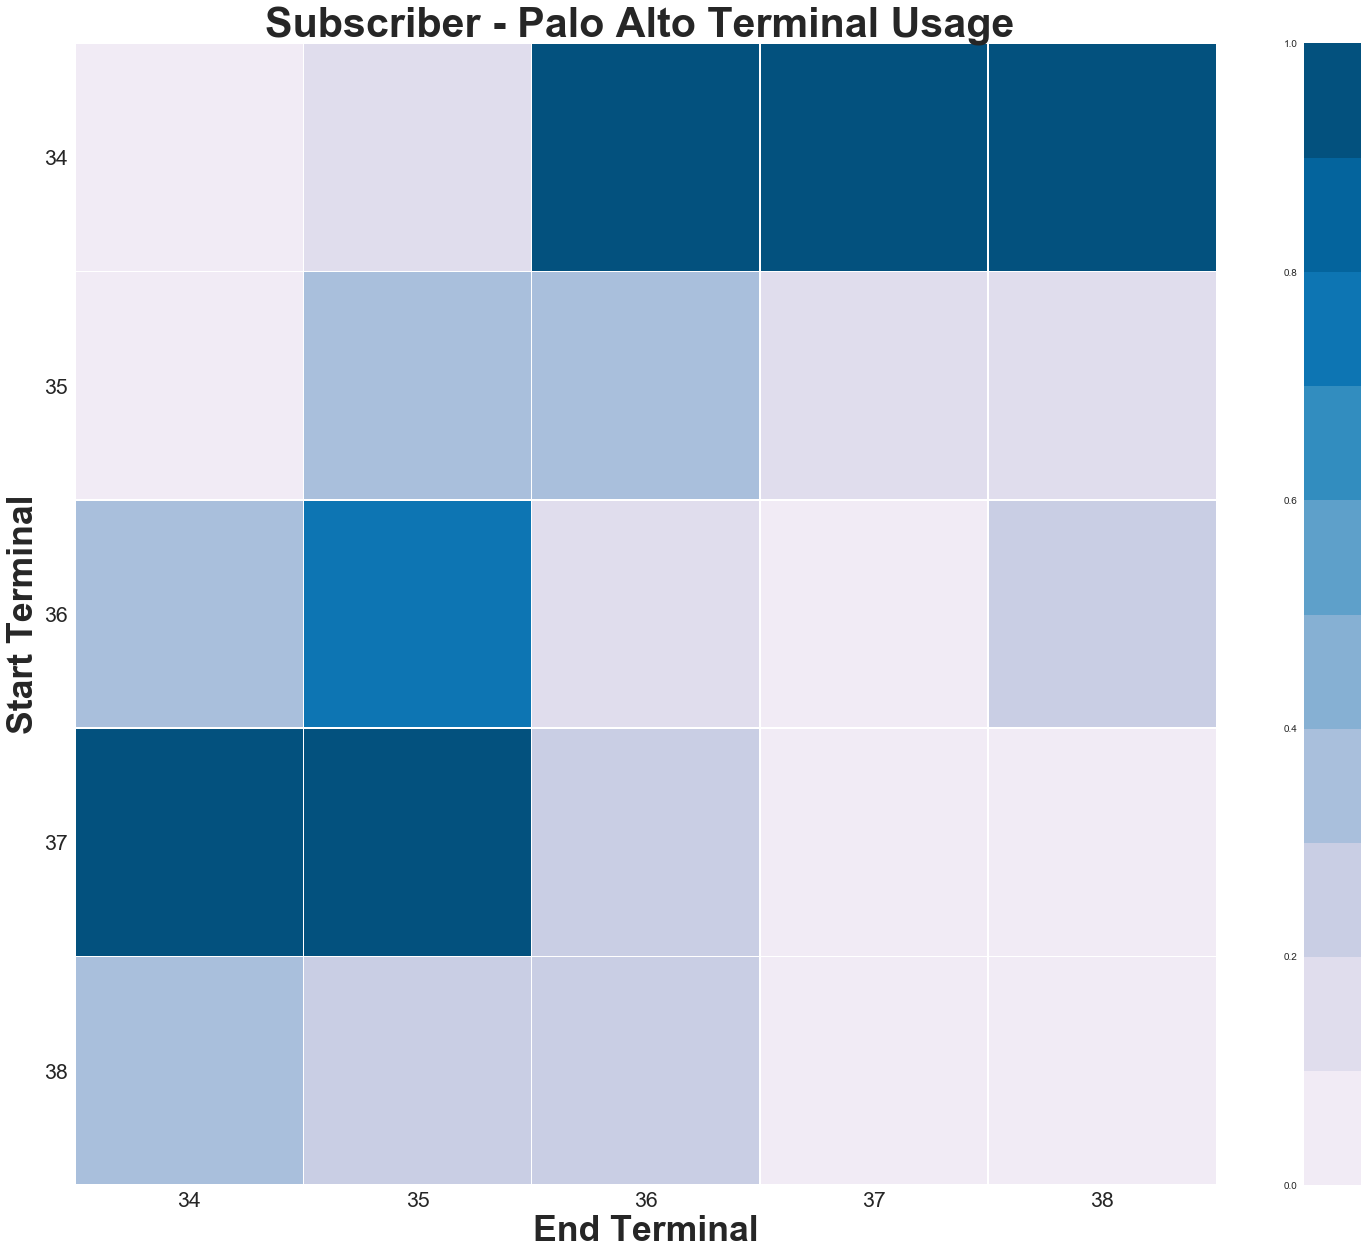

Total Trips in San Jose	43978	5.21


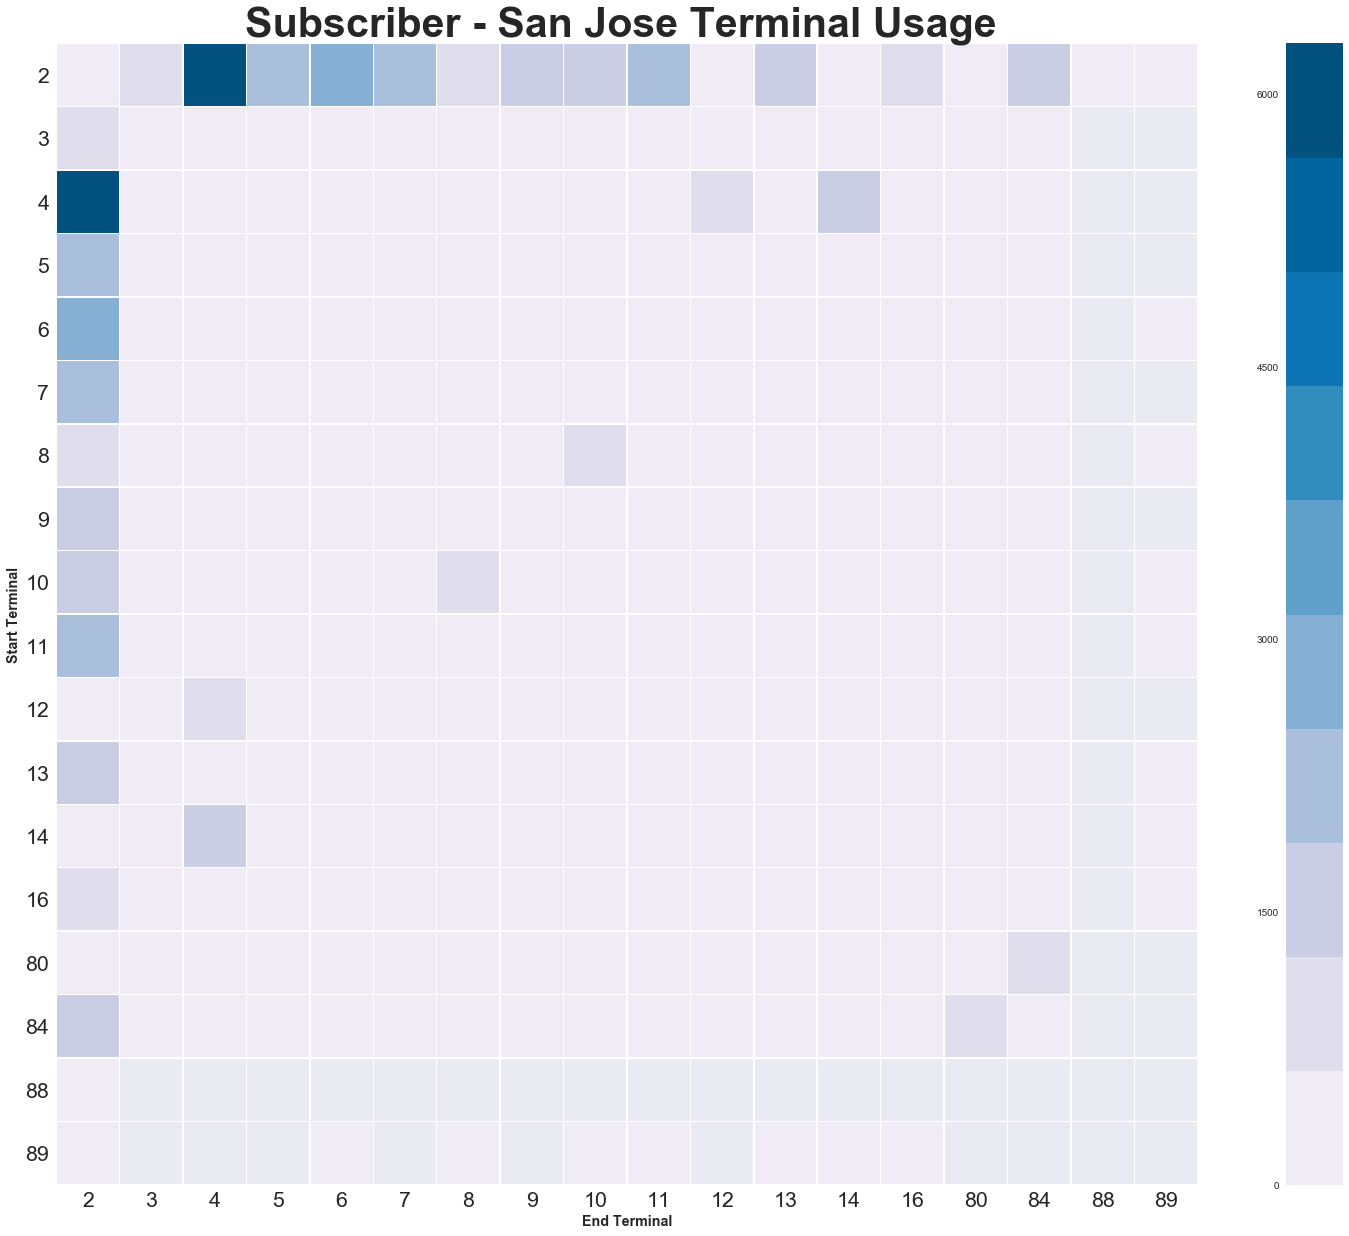

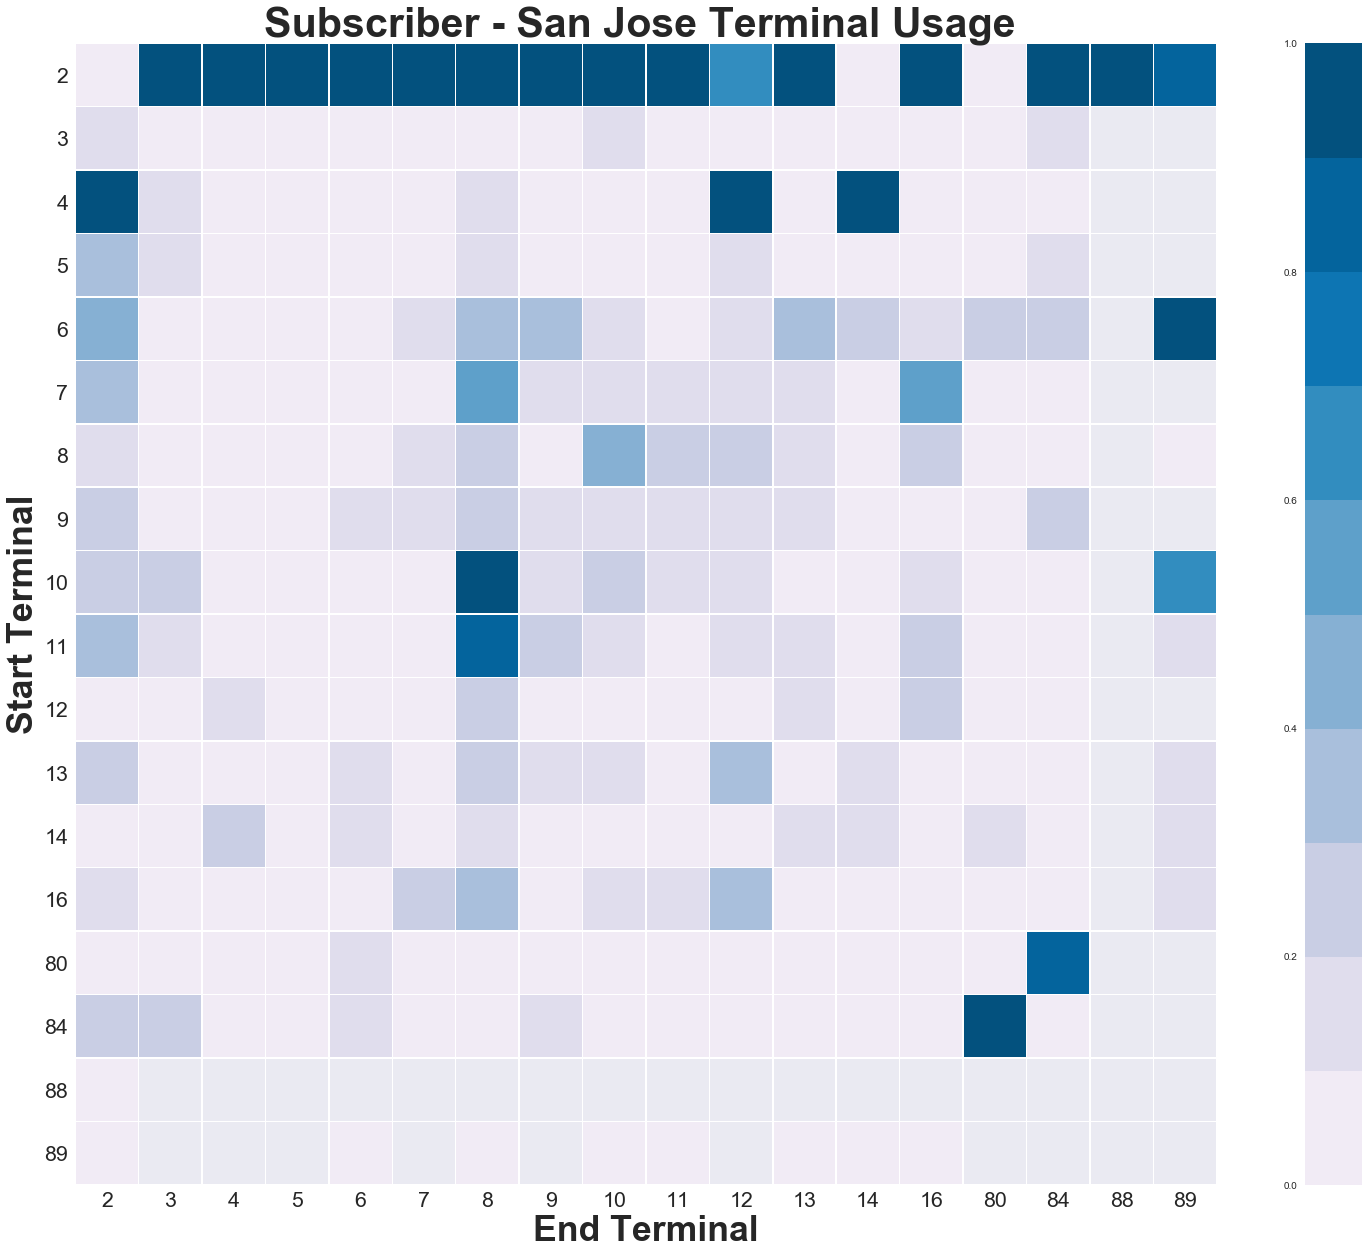

In [18]:
heatmap_regonalized_trips(trip_data, user_type='Subscriber')

### Customer Terminal Usage - By Region

Regional Terminal Usage		 110524
Non Regional Terminal Usage	    463		0.42
--------------------------------------------------------------------------------
Total Trips in Mountain View	2392	2.16


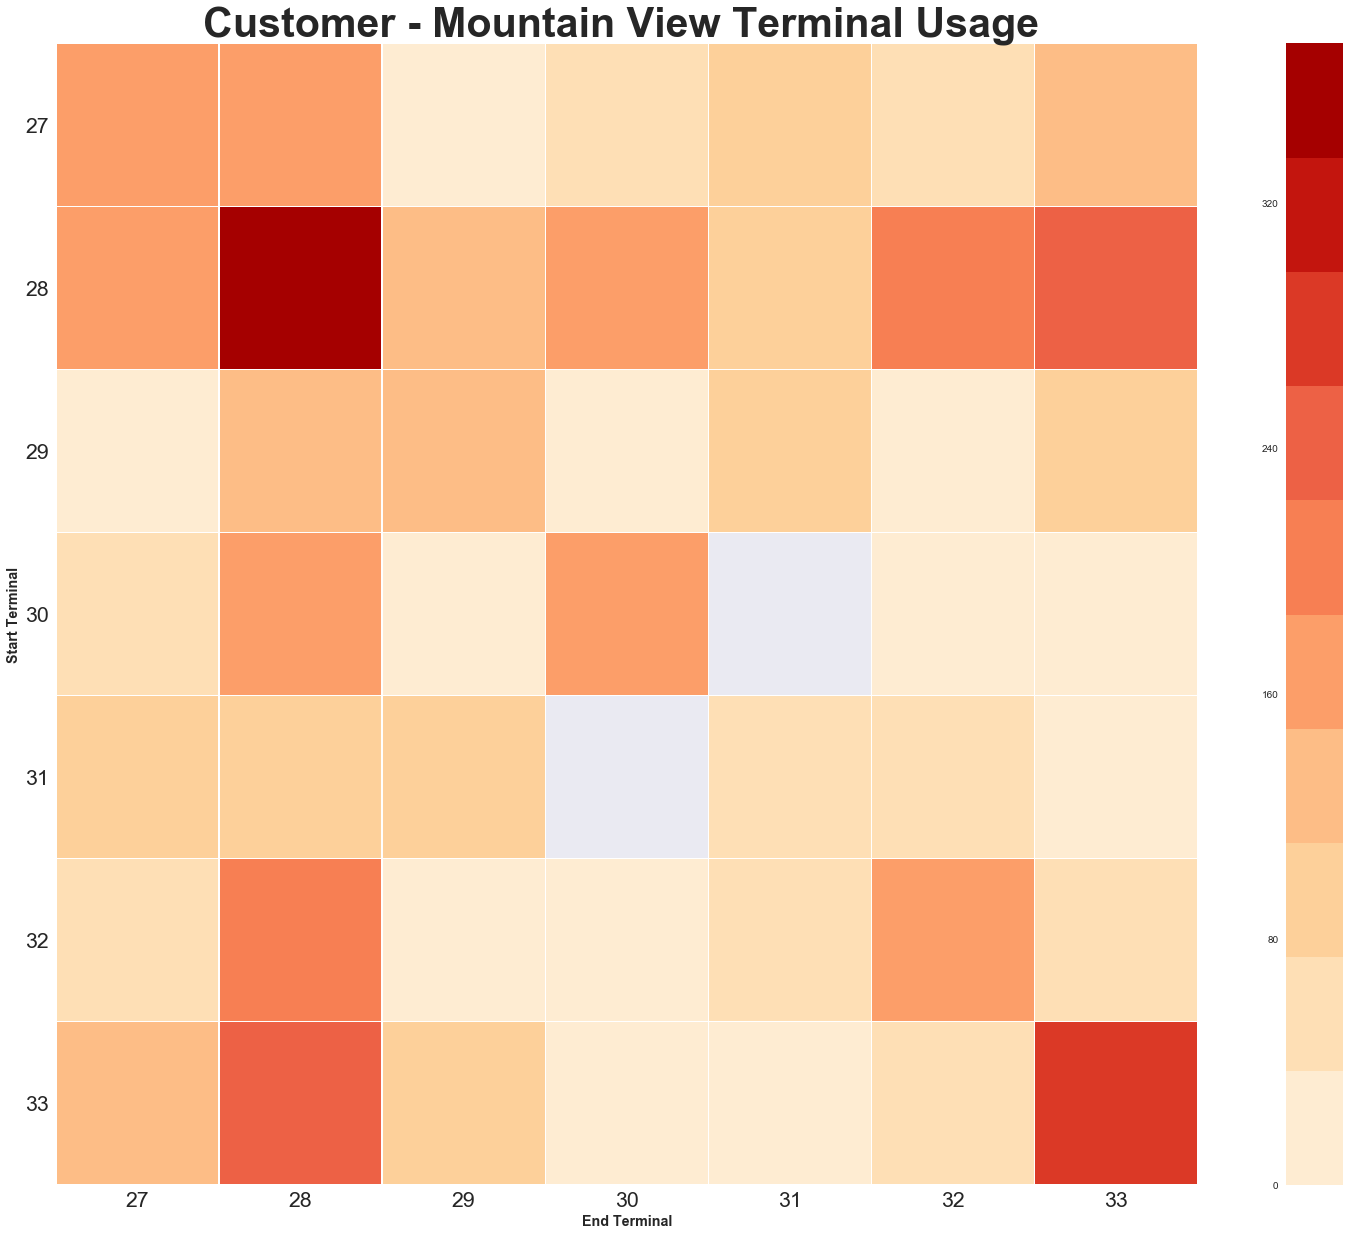

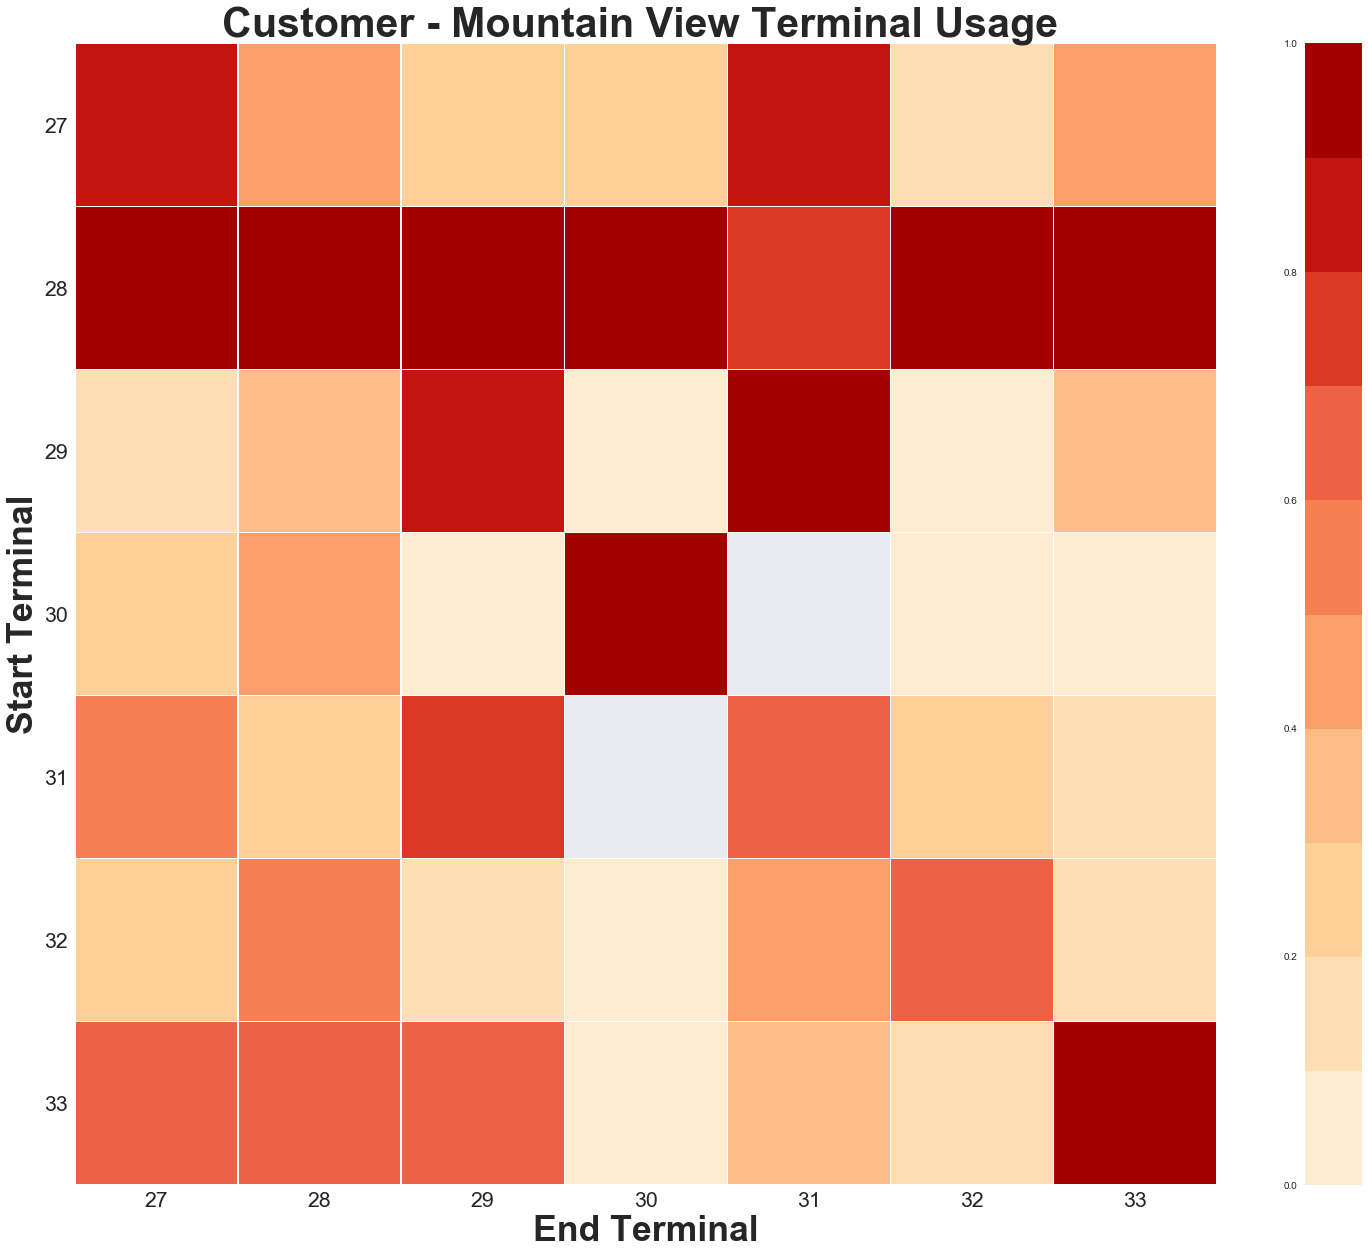

Total Trips in Redwood City	506	0.46


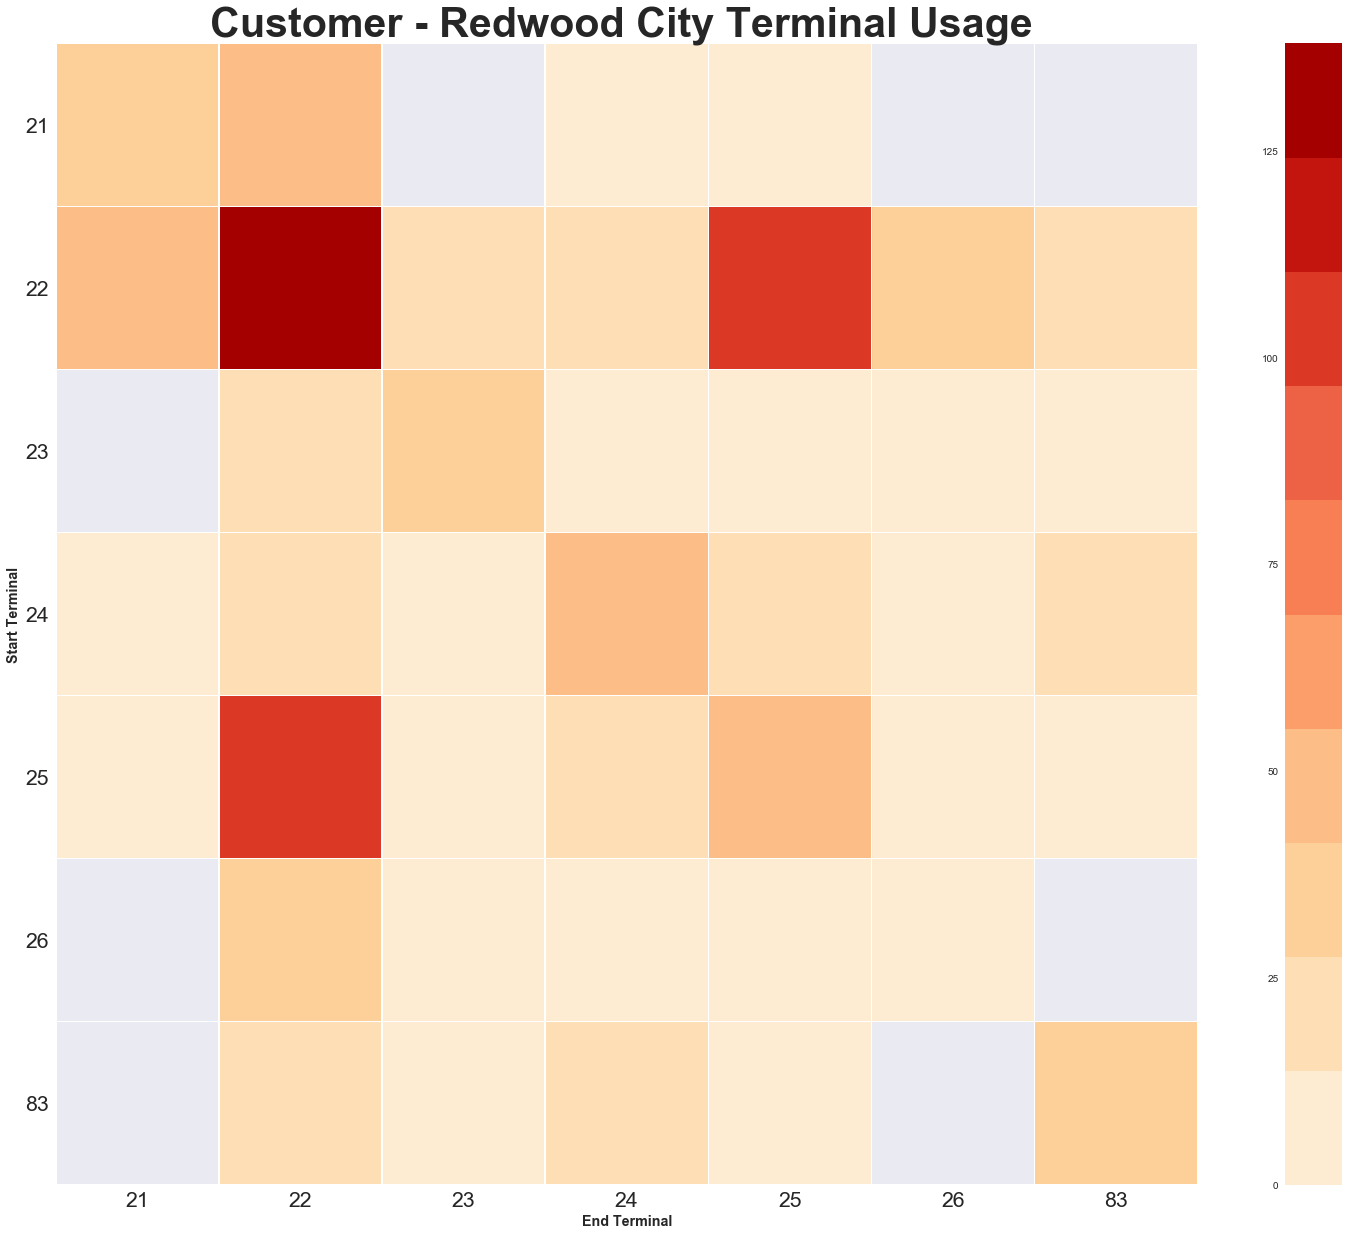

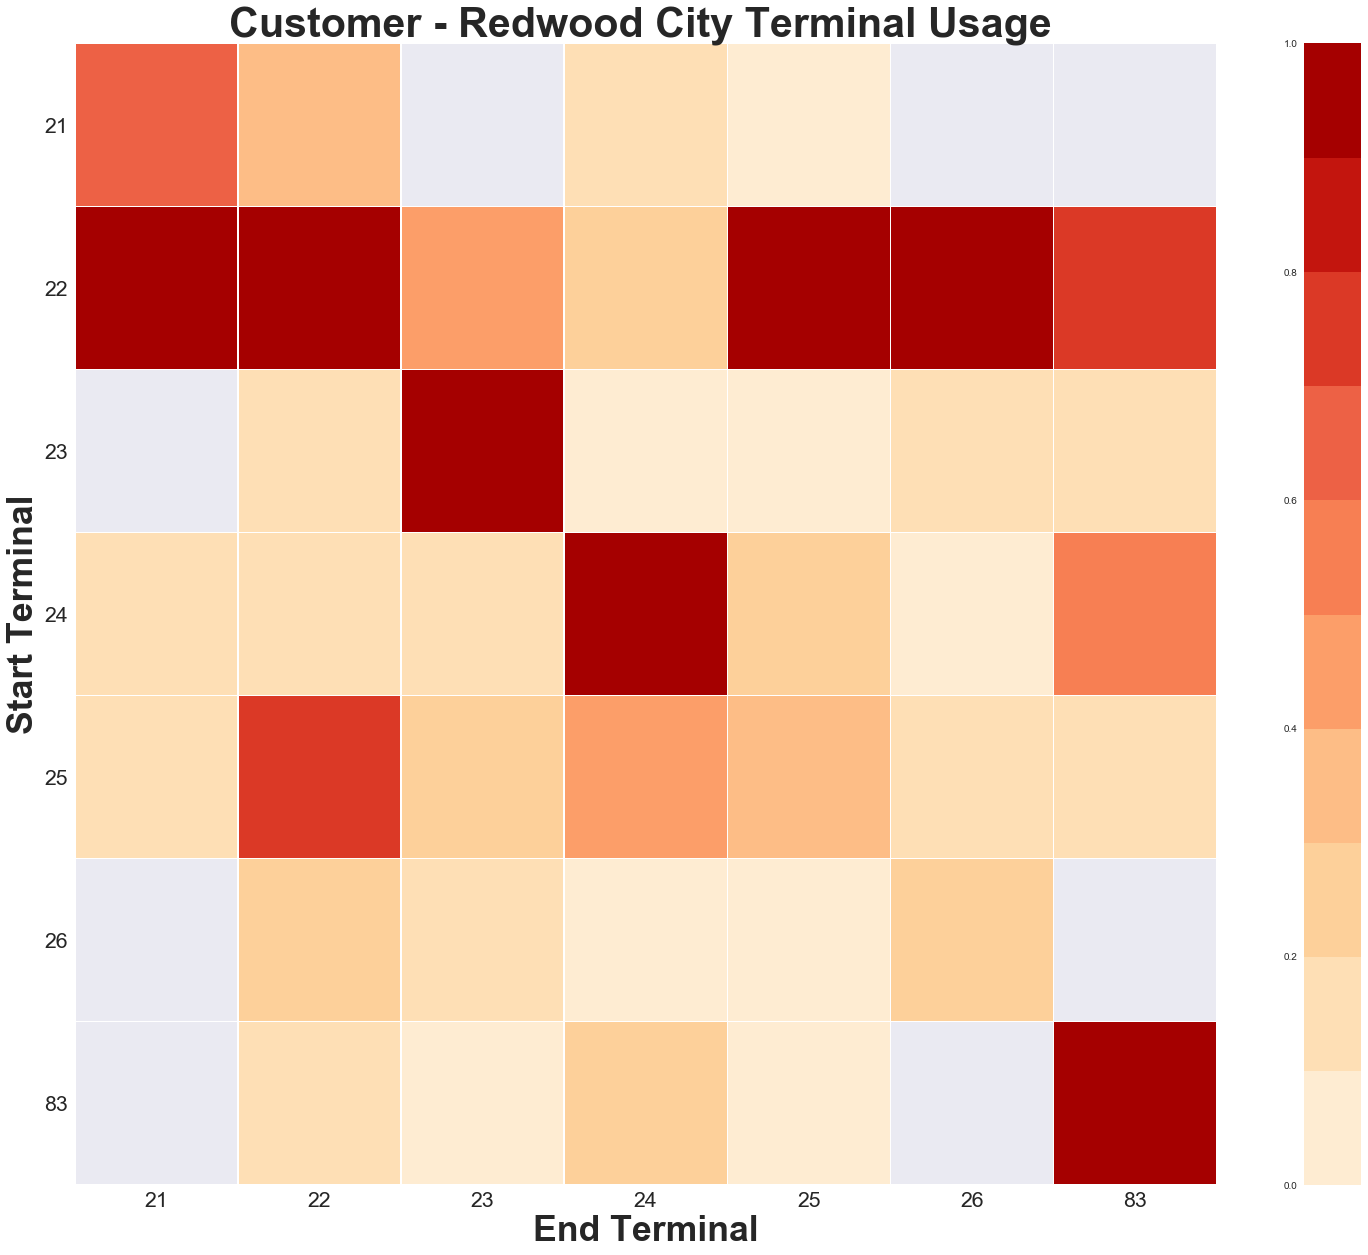

Total Trips in San Francisco	98531	89.15


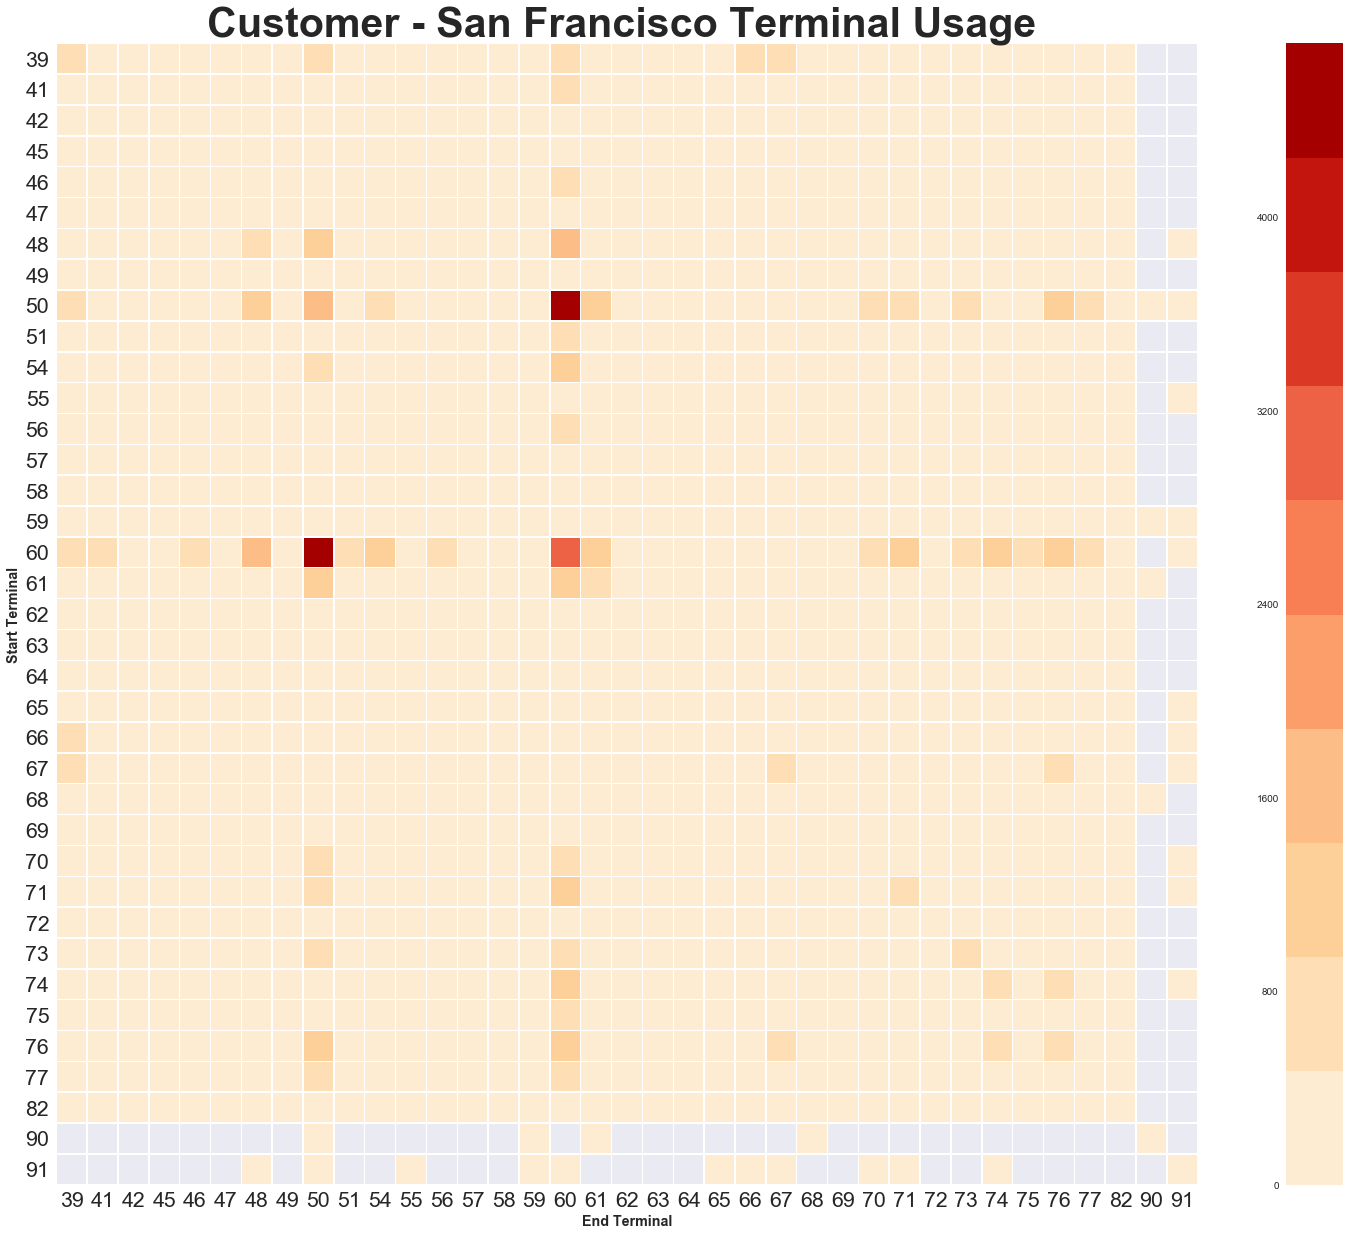

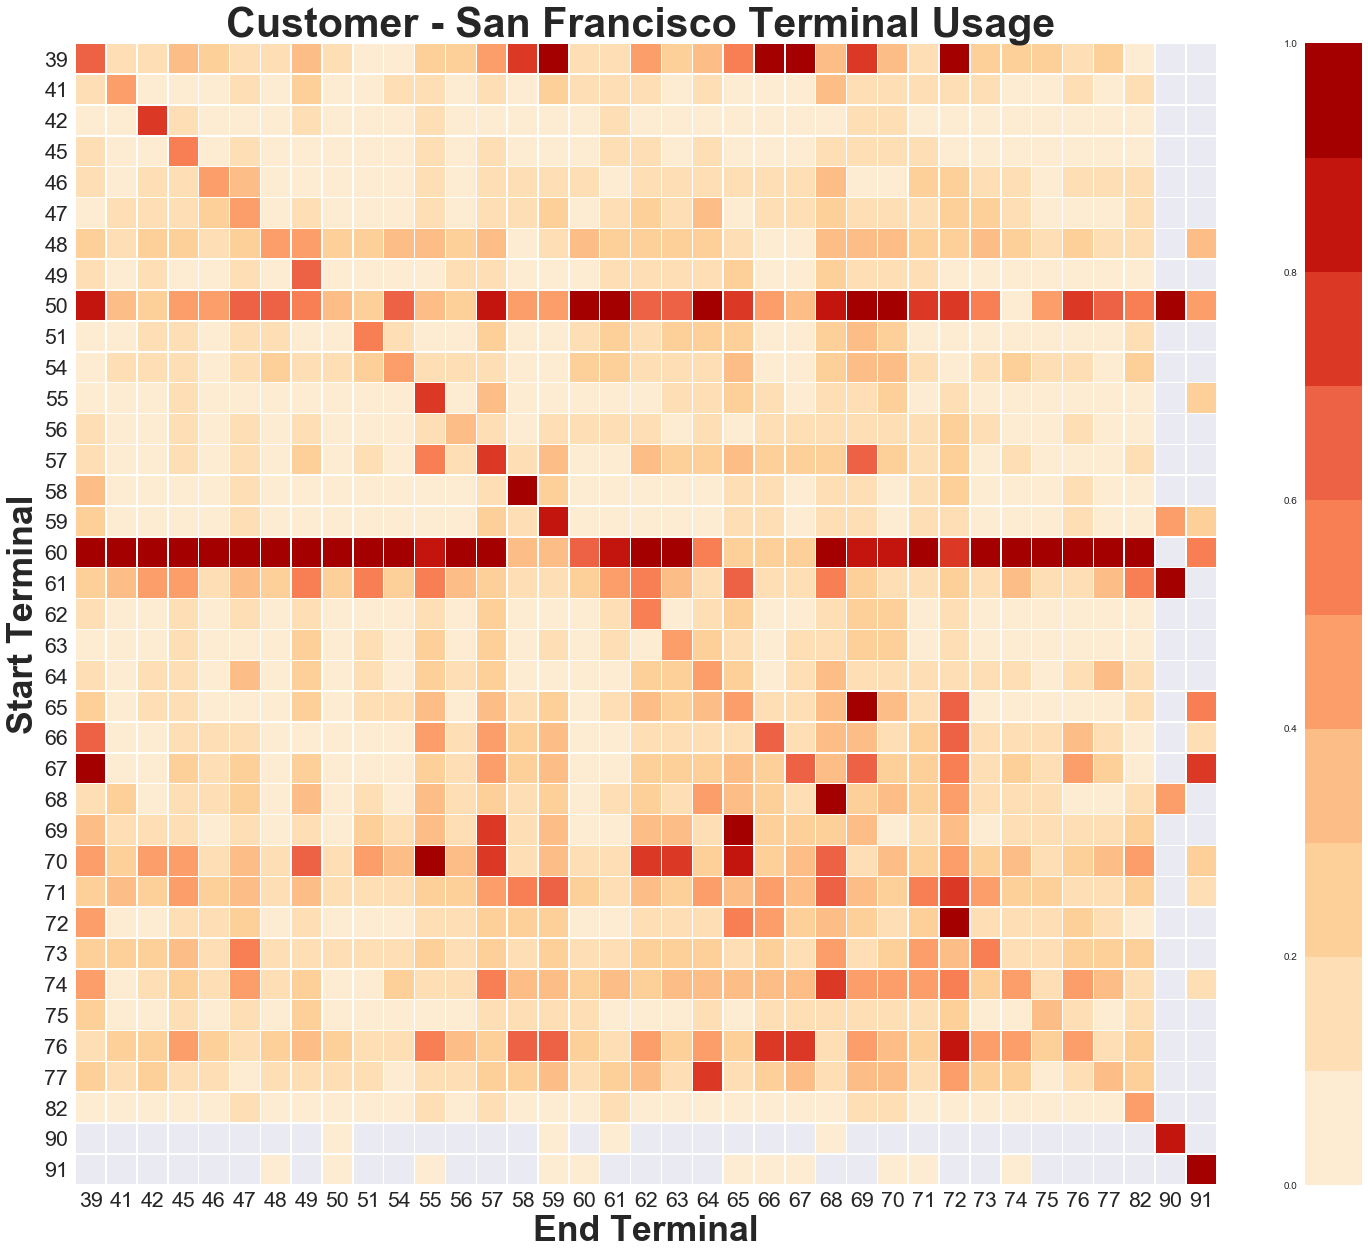

Total Trips in Palo Alto	2061	1.86


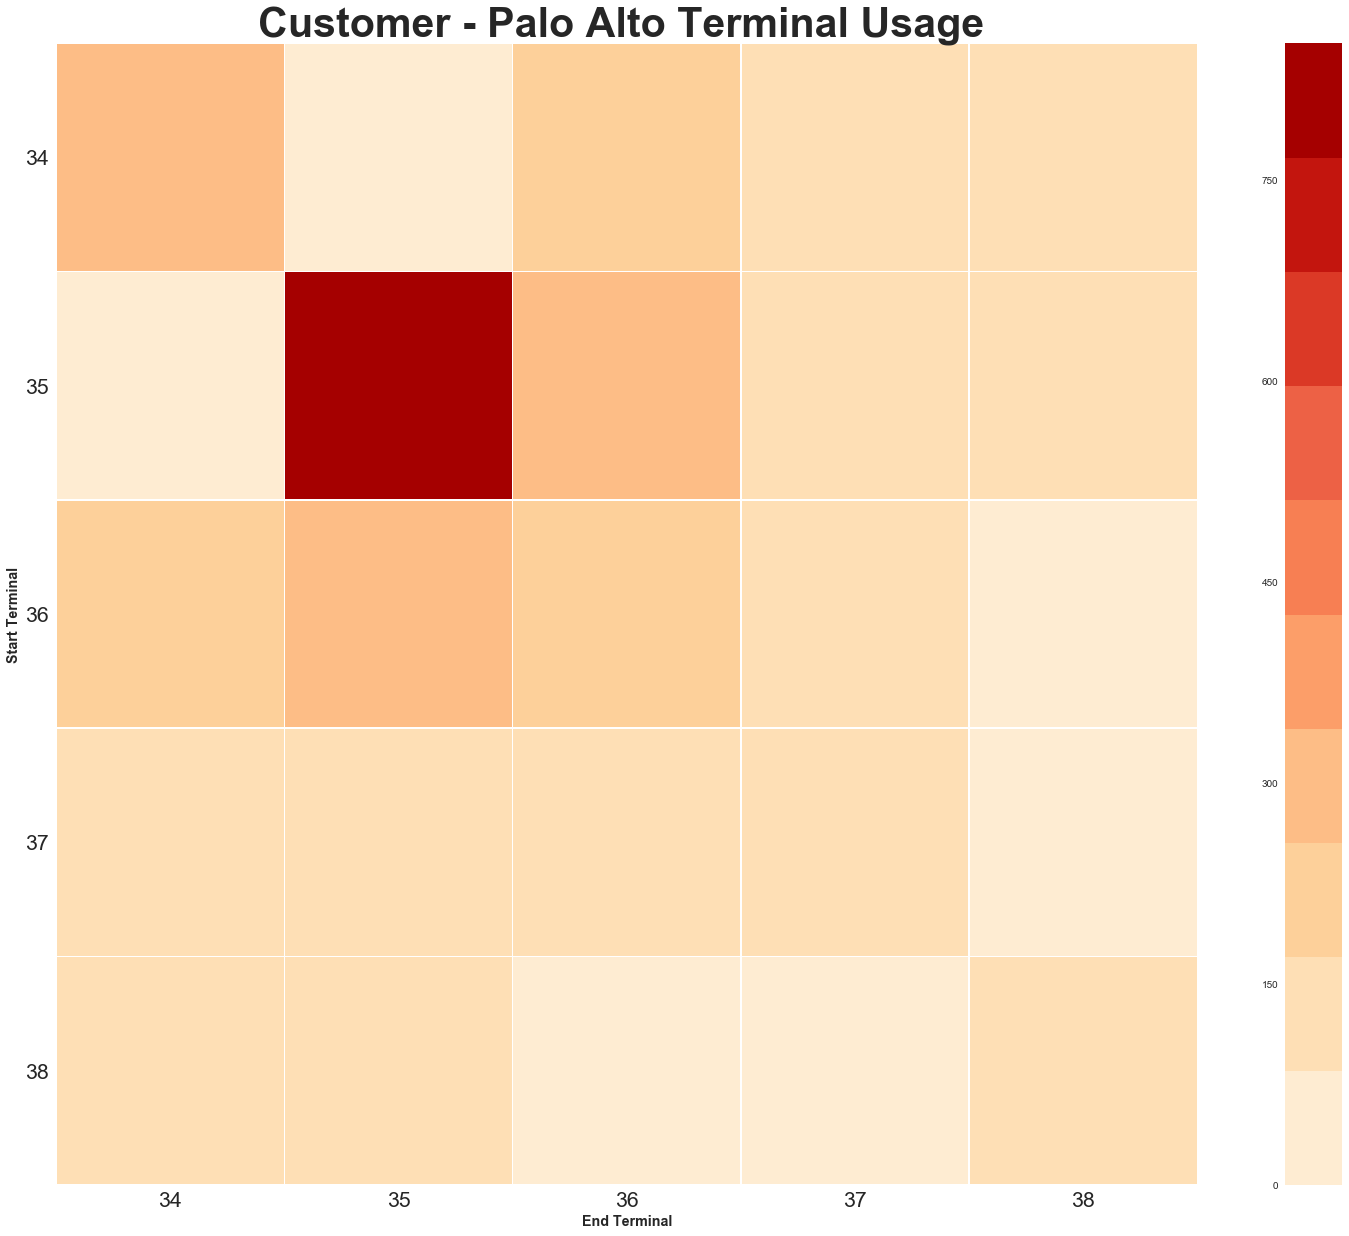

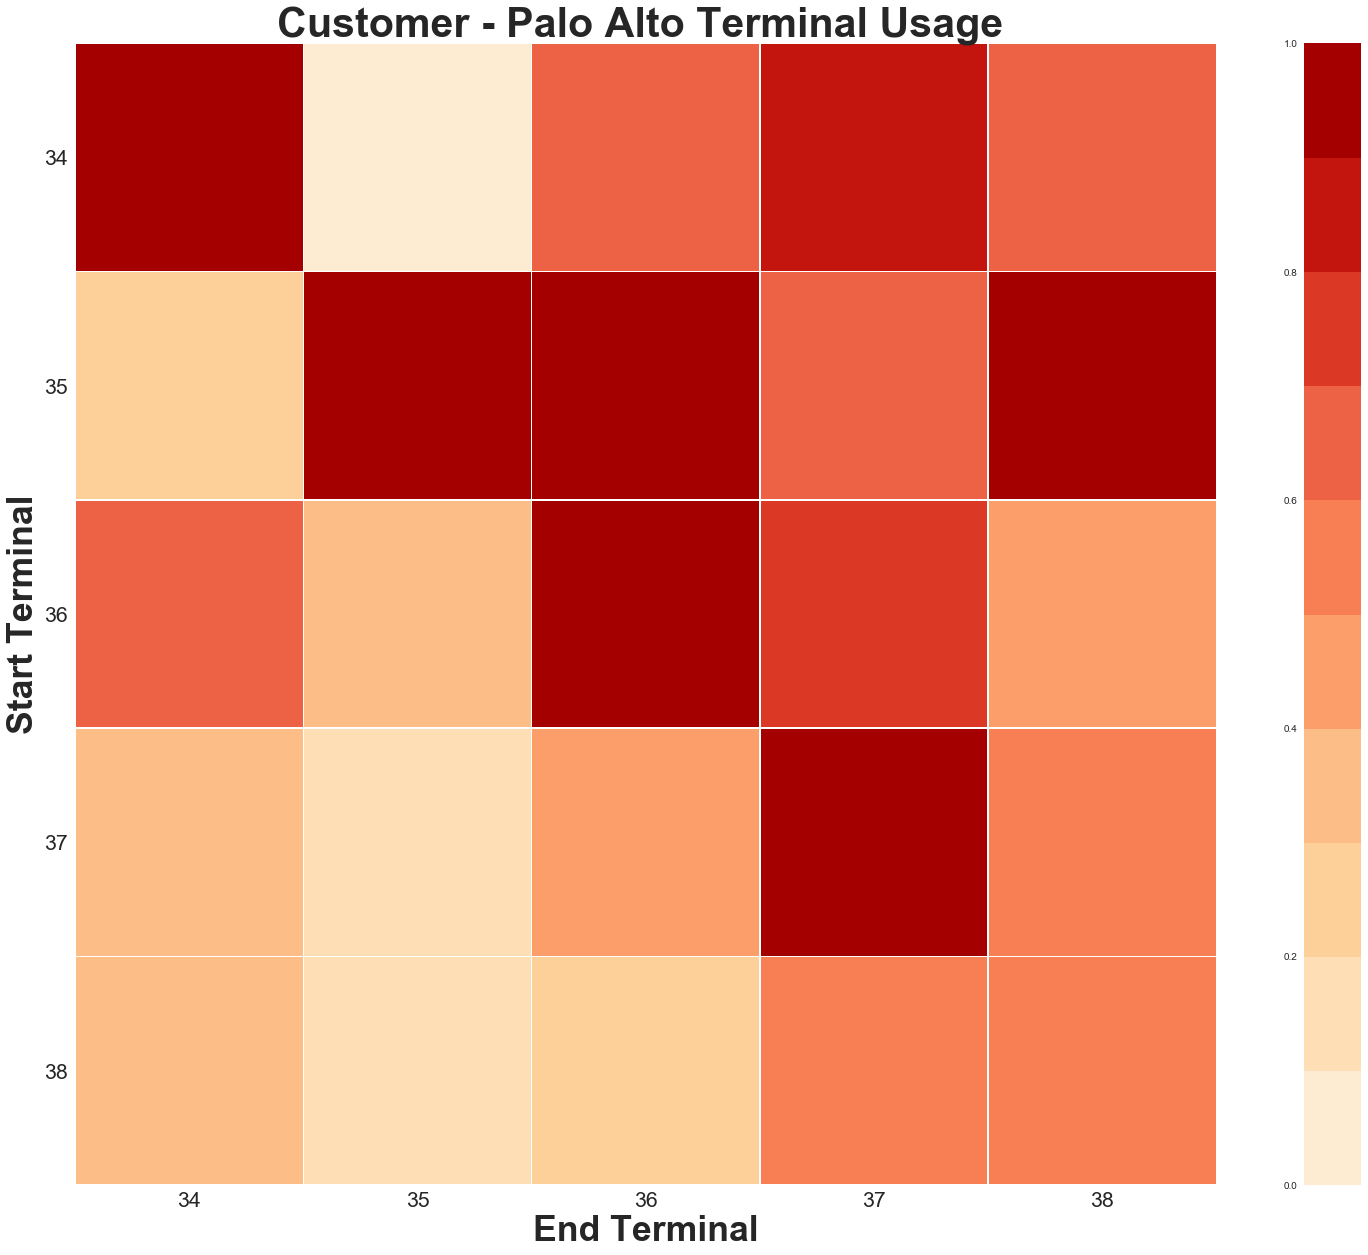

Total Trips in San Jose	7034	6.36


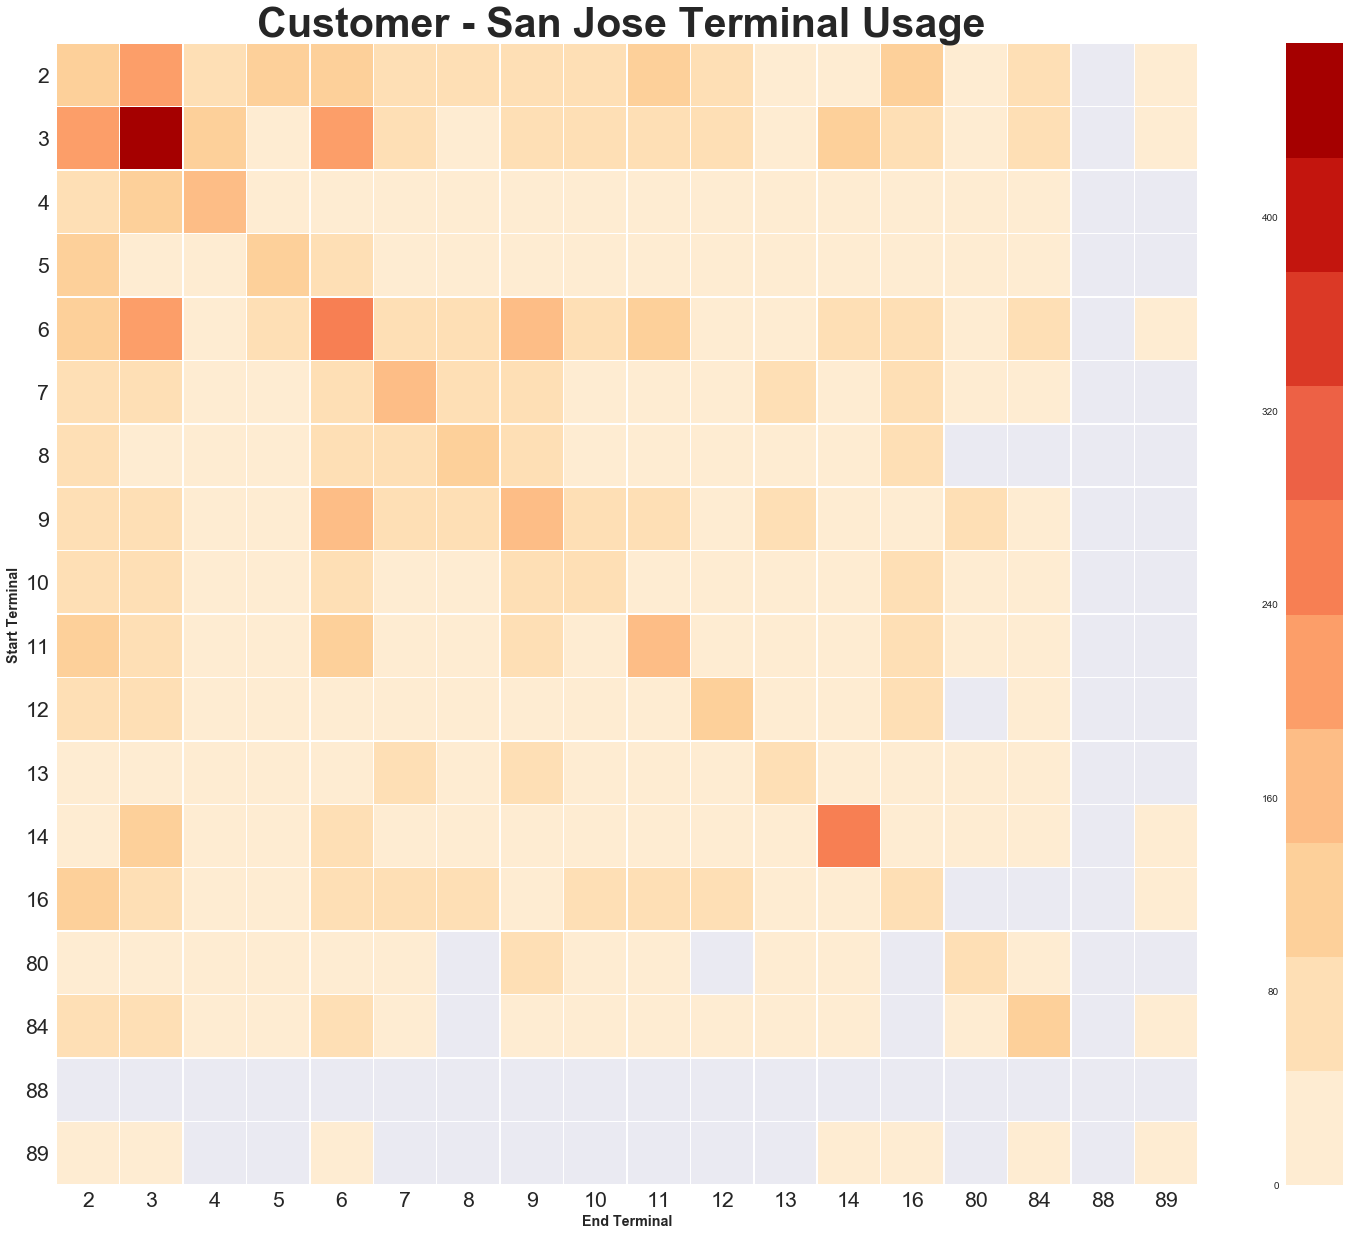

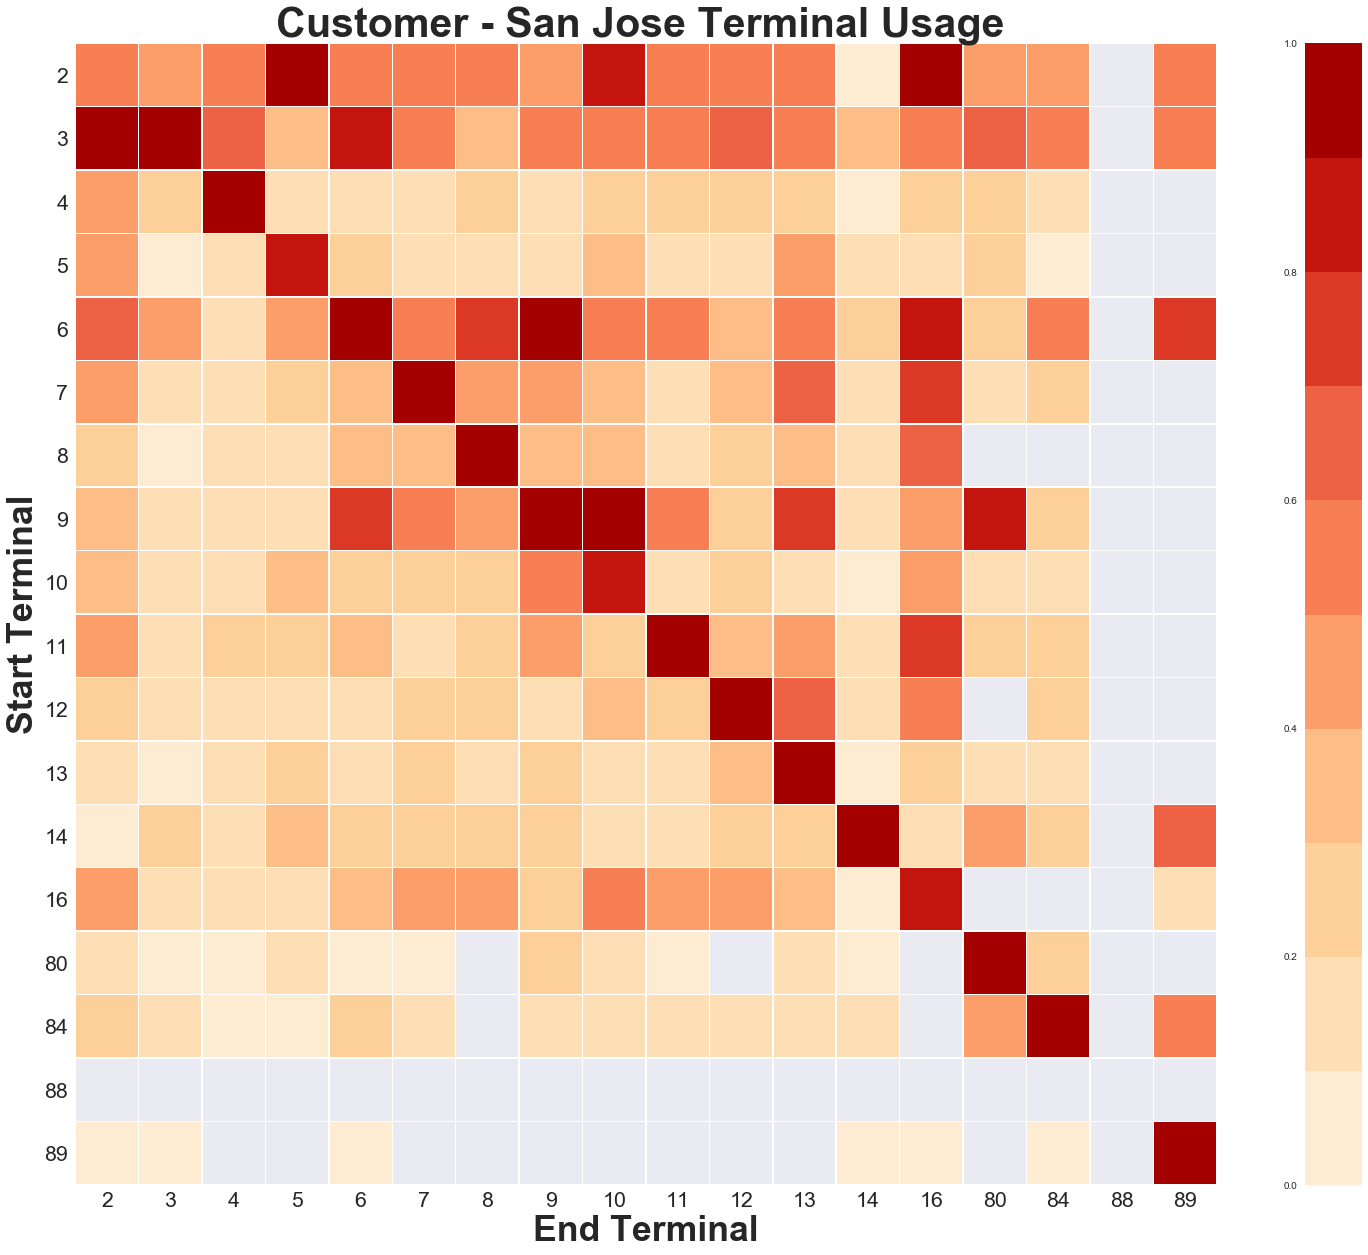

In [19]:
heatmap_regonalized_trips(trip_data, user_type='Customer')

# Top Subscriber Stations - Start, End, Total

## Load Station Data

In [20]:
station_data = pd.DataFrame()

station_data = pd.read_csv('../FINAL/clean_data/station_data_cleaned.csv', index_col=0, parse_dates=['last_service_date', 'first_service_date'])
station_data.head()

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098


In [21]:
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 10 columns):
station_id            79 non-null int64
name                  79 non-null object
lat                   79 non-null float64
long                  79 non-null float64
dock_count            79 non-null int64
landmark              79 non-null object
first_service_date    79 non-null datetime64[ns]
last_service_date     79 non-null datetime64[ns]
zip_code              79 non-null int64
days_in_service       79 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(4), object(2)
memory usage: 6.8+ KB


# Define 'Commuter'

> San Francisco Commuter Trip: a trip taken by a Subscriber, within San Francisco, on weekdays between 7am and 10am or between 4pm and 8pm

In [22]:
subscriber_data = trip_data[(trip_data.user_type == 'Subscriber') & (trip_data.start_zip == 94107) & (trip_data.end_zip == 94107)].copy()

# Define commute Hours
morning_commute_hours = [ 7, 10]
evening_commute_hours = [16, 20]

# morning_commuter_data are subscriber trips during morning commute hours, on weekdays only, San Francisco Only
morning_commuter_data = subscriber_data[(subscriber_data.start_date.dt.hour >= morning_commute_hours[0]) & (subscriber_data.start_date.dt.hour <= morning_commute_hours[1])]
morning_commuter_data = morning_commuter_data[morning_commuter_data.start_date.dt.dayofweek < 5]

# evening_commuter_data are subscriber trips during evening commute hours, on weekdays only, San Francisco Only
evening_commuter_data = subscriber_data[(subscriber_data.start_date.dt.hour >= evening_commute_hours[0]) & (subscriber_data.start_date.dt.hour <= evening_commute_hours[1])]
evening_commuter_data = evening_commuter_data[evening_commuter_data.start_date.dt.dayofweek < 5]

commuter_data = pd.concat([morning_commuter_data, evening_commuter_data])


In [23]:
print('Dataset\t\t\t    Number of Trips\t    Share of All Trips')
print('All Trip Data\t\t\t%s\t\t\t%0.2f' % (len(trip_data), (len(trip_data)/len(trip_data)*100.)))
print('Subscriber Data\t\t\t%s\t\t\t %0.2f' % (len(subscriber_data), (len(subscriber_data))/len(trip_data)*100.))
print('Commuter Data\t\t\t%s\t\t\t %0.2f' % (len(commuter_data), (len(commuter_data))/len(trip_data)*100.))
print('Morning Commuter Data\t\t%s\t\t\t %0.2f' % (len(morning_commuter_data), (len(morning_commuter_data))/len(trip_data)*100.))
print('Evening Commuter Data\t\t%s\t\t\t %0.2f' % (len(evening_commuter_data), (len(evening_commuter_data))/len(trip_data)*100.))

print('')
# number of commuting days
commute_day_count = len(pd.unique(commuter_data.start_date.dt.date))
print('There are %s commute days in the data set' % commute_day_count)

Dataset			    Number of Trips	    Share of All Trips
All Trip Data			955557			100.00
Subscriber Data			769677			 80.55
Commuter Data			554588			 58.04
Morning Commuter Data		279169			 29.22
Evening Commuter Data		275419			 28.82

There are 785 commute days in the data set


## Identify Top Stations

In [24]:
def top_stations(df, col='start_terminal'):
    top_df = df.groupby(col)['trip_id'].count()
    top_df = top_df.to_frame()
    top_df.sort_values('trip_id', inplace=True, ascending=False)
    top_df.reset_index(inplace=True, drop=False)
    cum_trips = top_df['trip_id'].sum()
    top_df['share'] = top_df['trip_id'] / cum_trips * 100.
    top_df.columns = ['station_id', 'trip_count', 'trip_share']
    return top_df

In [25]:
top_morning_commute_start_stations = top_stations(morning_commuter_data, col='start_terminal')
top_morning_commute_start_stations = pd.merge(top_morning_commute_start_stations, station_data[['station_id', 'name', 'days_in_service', 'dock_count']], on='station_id')
top_morning_commute_start_stations['trips_per_day'] = top_morning_commute_start_stations['trip_count'] / top_morning_commute_start_stations['days_in_service']

top_morning_commute_end_stations   = top_stations(morning_commuter_data, col='end_terminal')
top_morning_commute_end_stations = pd.merge(top_morning_commute_end_stations, station_data[['station_id', 'name', 'days_in_service', 'dock_count']], on='station_id')
top_morning_commute_end_stations['trips_per_day'] = top_morning_commute_end_stations['trip_count'] / top_morning_commute_end_stations['days_in_service']

top_evening_commute_start_stations = top_stations(evening_commuter_data, col='start_terminal')
top_evening_commute_start_stations = pd.merge(top_evening_commute_start_stations, station_data[['station_id', 'name', 'days_in_service', 'dock_count']], on='station_id')
top_evening_commute_start_stations['trips_per_day'] = top_evening_commute_start_stations['trip_count'] / top_evening_commute_start_stations['days_in_service']

top_evening_commute_end_stations   = top_stations(evening_commuter_data, col='end_terminal')
top_evening_commute_end_stations = pd.merge(top_evening_commute_end_stations, station_data[['station_id', 'name', 'days_in_service', 'dock_count']], on='station_id')
top_evening_commute_end_stations['trips_per_day'] = top_evening_commute_end_stations['trip_count'] / top_evening_commute_end_stations['days_in_service']

In [26]:
top_morning_commute_start_stations.head(12)

,station_id,trip_count,trip_share,name,days_in_service,dock_count,trips_per_day
0,70,40702,14.579699,San Francisco Caltrain (Townsend at 4th),1098,19,37.069217
1,69,32502,11.642410,San Francisco Caltrain 2 (330 Townsend),1098,23,29.601093
2,50,20179,7.228238,Harry Bridges Plaza (Ferry Building),1098,23,18.377960
3,55,19533,6.996837,Temporary Transbay Terminal (Howard at Beale),1098,23,17.789617
4,74,15620,5.595177,Steuart at Market,1098,23,14.225865
5,61,11479,4.111846,2nd at Townsend,1098,27,10.454463
6,73,10666,3.820625,Grant Avenue at Columbus Avenue,628,15,16.984076
7,73,10666,3.820625,Grant Avenue at Columbus Avenue,470,19,22.693617
8,77,8975,3.214899,Market at Sansome,1098,27,8.173953
9,54,8265,2.960572,Embarcadero at Bryant,1098,15,7.527322


In [27]:
top_morning_commute_end_stations.head(12)

,station_id,trip_count,trip_share,name,days_in_service,dock_count,trips_per_day
0,70,21220,7.601130,San Francisco Caltrain (Townsend at 4th),1098,19,19.326047
1,65,18273,6.545498,Townsend at 7th,1098,15,16.642077
2,61,18257,6.539766,2nd at Townsend,1098,27,16.627505
3,77,14105,5.052495,Market at Sansome,1098,27,12.846084
4,69,11946,4.279128,San Francisco Caltrain 2 (330 Townsend),1098,23,10.879781
5,60,11676,4.182413,Embarcadero at Sansome,1098,15,10.633880
6,55,11549,4.136921,Temporary Transbay Terminal (Howard at Beale),1098,23,10.518215
7,51,11332,4.059190,Embarcadero at Folsom,1098,19,10.320583
8,63,11220,4.019071,Howard at 2nd,1098,19,10.218579
9,74,11060,3.961758,Steuart at Market,1098,23,10.072860


In [28]:
top_evening_commute_start_stations.head(12)

,station_id,trip_count,trip_share,name,days_in_service,dock_count,trips_per_day
0,70,17020,6.179675,San Francisco Caltrain (Townsend at 4th),1098,19,15.500911
1,65,16152,5.864519,Townsend at 7th,1098,15,14.710383
2,61,14244,5.171756,2nd at Townsend,1098,27,12.972678
3,69,12891,4.680505,San Francisco Caltrain 2 (330 Townsend),1098,23,11.740437
4,77,12802,4.648191,Market at Sansome,1098,27,11.659381
5,64,11995,4.355182,2nd at South Park,1098,15,10.924408
6,60,11464,4.162385,Embarcadero at Sansome,1098,15,10.440801
7,67,11021,4.001539,Market at 10th,1098,27,10.037341
8,55,10943,3.973219,Temporary Transbay Terminal (Howard at Beale),1098,23,9.966302
9,74,10927,3.967410,Steuart at Market,1098,23,9.951730


In [29]:
top_evening_commute_end_stations.head(12)

,station_id,trip_count,trip_share,name,days_in_service,dock_count,trips_per_day
0,70,47621,17.290383,San Francisco Caltrain (Townsend at 4th),1098,19,43.370674
1,69,33309,12.093937,San Francisco Caltrain 2 (330 Townsend),1098,23,30.336066
2,50,18350,6.662576,Harry Bridges Plaza (Ferry Building),1098,23,16.712204
3,55,16109,5.848907,Temporary Transbay Terminal (Howard at Beale),1098,23,14.671220
4,74,15889,5.769028,Steuart at Market,1098,23,14.470856
5,77,11863,4.307255,Market at Sansome,1098,27,10.804189
6,61,11313,4.107560,2nd at Townsend,1098,27,10.303279
7,65,9341,3.391560,Townsend at 7th,1098,15,8.507286
8,39,8394,3.047720,Powell Street BART,1098,19,7.644809
9,60,8121,2.948598,Embarcadero at Sansome,1098,15,7.396175


# Test Resiliency of San Francisco Commuters

In [30]:
def hypothesis_test(A, B):
    # calculate Means
    A_data = A.copy()
    B_data = B.copy()

    A_mean = A_data.mean()
    B_mean = B_data.mean()
    diff_mean = A_mean - B_mean

    # Variance
    A_var = A_data.var()
    B_var = B_data.var()

    # Length
    A_count = len(A_data)
    B_count = len(B_data)
    
    # Junk
    A_sum = A_data.sum()
    B_sum = B_data.sum()

    # Standard Deviation
    std_error = math.sqrt(A_var/A_count + B_var/B_count)

    # Margin of Error
    margin = 1.96*std_error

    # calculate t statistic and p value with scipy
    t, p = stats.ttest_ind(A_data, B_data)

    reject_null = False

    if p < 0.05:
        reject_null = True
    else:
        reject_null = False

    result = [A_mean, B_mean, A_sum, B_sum, A_count, B_count, diff_mean, std_error, margin, t, p, reject_null]

    return result

In [31]:
commuter_data.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,date,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


# Test 1 - Does Temperature Affect Commuter Ridership


Temperature ranges are defined by calculating standard deviations in the Mean Temperature

> Define 'Hot Days' as days with Max Temperature greater than 1 standard deviation above the mean Max Temperature
>
> Define 'Cold Days' as days with Min Temperature less than 1 standard deviation below the mean Min Temperature
>
> Define 'Normal Days' as days with a Min temperature greater than 1 standard deviation below the mean Min Temperature <b>AND</b> Max Temperature less than 1 standard deviation above the mean Max Temperature

## Results Quickview

> Commuter trip numbers <b>are</b> meaningfully affected by hotter temperatures.  Mean trip count increases 8.76%, or average 62.68 more trips, on days with a Maximum Temperature above 75.86 degrees Fahrenheit
>
> Commuter trip numbers <b>are</b> meaningfully affected by colder temperatures.  Mean trip count drops 14.70%, or average 105.17 fewer trips, on days with a Minimum Temperature below 45.41 degrees Fahrenheit

In [32]:
# Calculate Max Temperature 1 standard deviation above average Max Temperature
max_temp_MEAN = commuter_data.groupby(commuter_data.start_date.dt.date)['max_temp'].mean().mean()
max_temp_STD = commuter_data.groupby(commuter_data.start_date.dt.date)['max_temp'].mean().std()
hot_day_cuttoff = max_temp_MEAN + max_temp_STD
print('hot_day_cuttoff\t\t%s' % hot_day_cuttoff)

# Calculate Min Temperature 1 standard deviation below average Min Temperature
min_temp_MEAN = commuter_data.groupby(commuter_data.start_date.dt.date)['min_temp'].mean().mean()
min_temp_STD = commuter_data.groupby(commuter_data.start_date.dt.date)['min_temp'].mean().std()
cold_day_cuttoff = min_temp_MEAN - min_temp_STD
print('cold_day_cuttoff\t%s' % cold_day_cuttoff)

# subset data
hot_data  = commuter_data[commuter_data.max_temp >= hot_day_cuttoff]
cold_data = commuter_data[commuter_data.min_temp <= cold_day_cuttoff]
norm_data = commuter_data[(commuter_data.max_temp < hot_day_cuttoff) & (commuter_data.min_temp > cold_day_cuttoff)]

# trip counts by date for each subset
hot_day_data  = hot_data.groupby(hot_data.start_date.dt.date)['trip_id'].count()
print('Number of hot days\t%s' % len(hot_day_data))
cold_day_data = cold_data.groupby(cold_data.start_date.dt.date)['trip_id'].count()
print('Number of cold days\t%s' % len(cold_day_data))
norm_day_data = norm_data.groupby(norm_data.start_date.dt.date)['trip_id'].count()
print('Number of normal days\t%s' % len(norm_day_data))


total_hot_days = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.max_temp >= hot_day_cuttoff)]
total_cold_days = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.min_temp <= cold_day_cuttoff)]
total_normal_days = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.max_temp < hot_day_cuttoff) 
                             & (trip_data.min_temp > cold_day_cuttoff)]

print('\nNote: San Francisco saw %s total Hot days in all recorded data' % len(pd.unique(total_hot_days.start_date.dt.date)))
print('Note: San Francisco saw %s total Cold days in all recorded data' % len(pd.unique(total_cold_days.start_date.dt.date)))
print('Note: San Francisco saw %s total Normal days in all recorded data' % len(pd.unique(total_normal_days.start_date.dt.date)))

hot_day_cuttoff		75.8649258942
cold_day_cuttoff	45.4075613575
Number of hot days	113
Number of cold days	134
Number of normal days	538

Note: San Francisco saw 156 total Hot days in all recorded data
Note: San Francisco saw 186 total Cold days in all recorded data
Note: San Francisco saw 757 total Normal days in all recorded data


### Test 1a - Hot Days vs Normal Days
> $H$o : Number of Commuter Trips on Hot Days = Number of Commuter Trips on Normal Days
>
> $H$a : Number of Commuter Trips on Hot Days ≠ Number of Commuter Trips on Normal Days

### Result 1a - Number of Commuter Trips on Hot Days ≠ Number of Commuter Trips on Normal Days

> From calculations we arrive at <b>margin of error 35.48664</b>
> 
> From calculations we arrive at <b>mean difference 62.68656</b>, thus the $H$o is <b>rejected</b>
>
- T Statistic <b>3.32146</b> 
- P Value <b>0.00094</b> which is below the 0.05 threshhold thus we <b>can reject the $H$o</b>

In [33]:
# hot vs norm

hot_v_norm_test_results  = hypothesis_test(hot_day_data, norm_day_data)
print('Hot vs Normal Days')
print('-' * 80)
print('Hot Day Commuter Mean Trip Count\t%0.5f'    % hot_v_norm_test_results[0])
print('Normal Day Commuter Mean Trip Count\t%0.5f' % hot_v_norm_test_results[1])
print('Number of Hot Trips\t\t\t%s'                % hot_v_norm_test_results[2])
print('Number of Normal Trips\t\t\t%s'             % hot_v_norm_test_results[3])
print('Number of Hot Days\t\t\t%s'                 % hot_v_norm_test_results[4])
print('Number of Normal Days\t\t\t%s'              % hot_v_norm_test_results[5])
print('Difference of Means\t\t\t%0.5f'             % hot_v_norm_test_results[6])
print('Standard Error\t\t\t\t%0.5f'                % hot_v_norm_test_results[7])
print('Margin of Error\t\t\t\t%0.5f'               % hot_v_norm_test_results[8])
print('T-Score\t\t\t\t\t%0.5f'                     % hot_v_norm_test_results[9])
print('P-Value\t\t\t\t\t%s'                        % hot_v_norm_test_results[10])
print('Can Reject Null\t\t%s'                      % hot_v_norm_test_results[11])

hot_day_ridership_dip = (1 - hot_v_norm_test_results[0] / hot_v_norm_test_results[1]) * 100.
print('\nRidership increases by %0.2f percent on Hot Days' % (hot_day_ridership_dip * -1))

Hot vs Normal Days
--------------------------------------------------------------------------------
Hot Day Commuter Mean Trip Count	778.09735
Normal Day Commuter Mean Trip Count	715.41078
Number of Hot Trips			87925
Number of Normal Trips			384891
Number of Hot Days			113
Number of Normal Days			538
Difference of Means			62.68656
Standard Error				18.10543
Margin of Error				35.48664
T-Score					3.32146
P-Value					0.000945690516397
Can Reject Null		True

Ridership increases by 8.76 percent on Hot Days


### Test 1b - Cold Days vs Normal Days
> $H$o : Number of Commuter Trips on Cold Days = Number of Commuter Trips on Normal Days
>
> $H$a : Number of Commuter Trips on Cold Days ≠ Number of Commuter Trips on Normal Days

### Result 1b - Number of Commuter Trips on Cold Days ≠ Number of Commuter Trips on Normal Days

> From calculations we arrive at <b>margin of error 48.13000</b>
> 
> From calculations we arrive at <b>mean difference -105.17197</b>, thus the $H$o is <b>rejected</b>
>
- T Statistic <b>-5.34202</b> 
- P Value <b>1.26081e-07</b> which is below the 0.05 threshhold thus we <b>can reject the $H$o</b>

In [34]:
# cold vs norm

cold_v_norm_test_results  = hypothesis_test(cold_day_data, norm_day_data)
print('Cold vs Normal Days')
print('-' * 80)
print('Cold Day Commuter Mean Trip Count\t%0.5f'   % cold_v_norm_test_results[0])
print('Normal Day Commuter Mean Trip Count\t%0.5f' % cold_v_norm_test_results[1])
print('Number of Cold Trips\t\t\t%s'               % cold_v_norm_test_results[2])
print('Number of Normal Trips\t\t\t%s'             % cold_v_norm_test_results[3])
print('Number of Cold Days\t\t\t%s'                % cold_v_norm_test_results[4])
print('Number of Normal Days\t\t\t%s'              % cold_v_norm_test_results[5])
print('Difference of Means\t\t\t%0.5f'             % cold_v_norm_test_results[6])
print('Standard Error\t\t\t\t%0.5f'                % cold_v_norm_test_results[7])
print('Margin of Error\t\t\t\t%0.5f'               % cold_v_norm_test_results[8])
print('T-Score\t\t\t\t\t%0.5f'                     % cold_v_norm_test_results[9])
print('P-Value\t\t\t\t\t%s'                        % cold_v_norm_test_results[10])
print('Can Reject Null\t\t%s'                      % cold_v_norm_test_results[11])

cold_day_ridership_dip = (1 - cold_v_norm_test_results[0] / cold_v_norm_test_results[1]) * 100.
print('\nRidership dips by %0.2f percent on Cold Days' % cold_day_ridership_dip)

Cold vs Normal Days
--------------------------------------------------------------------------------
Cold Day Commuter Mean Trip Count	610.23881
Normal Day Commuter Mean Trip Count	715.41078
Number of Cold Trips			81772
Number of Normal Trips			384891
Number of Cold Days			134
Number of Normal Days			538
Difference of Means			-105.17197
Standard Error				24.55612
Margin of Error				48.13000
T-Score					-5.34202
P-Value					1.26081425943e-07
Can Reject Null		True

Ridership dips by 14.70 percent on Cold Days


## Test 1 Alternate - Using only Mean Temperature

> as a security check, compute the same temperature tests but this time using only the mean temperature to calculate mean, standard deviations, and the hot and cold cutoff temperatures.
>
> hot and cold days are calculated as days above and below one standard deviation from the mean_temp
>
> normal days are mean temperature within +/- one standard deviation from the mean mean_temp

## Results Quickview

> Commuter trip numbers <b>are</b> meaningfully affected by hotter temperatures.  Mean trip count increases 7.69%, or average 55.84 more trips, on days with a Mean Temperature above 66.65 degrees Fahrenheit
>
> Commuter trip numbers <b>are</b> meaningfully affected by colder temperatures.  Mean trip count drops 21.40%, or average 155.34 fewer trips, on days with a Mean Temperature below 54.04 degrees Fahrenheit

In [35]:
# Calculate Max Temperature 1 standard deviation above average Max Temperature
mean_temp_MEAN_ALT = commuter_data.groupby(commuter_data.start_date.dt.date)['mean_temp'].mean().mean()
mean_temp_STD_ALT = commuter_data.groupby(commuter_data.start_date.dt.date)['mean_temp'].mean().std()

hot_day_cuttoff_ALT = mean_temp_MEAN_ALT + mean_temp_STD_ALT
print('hot_day_cuttoff ', hot_day_cuttoff_ALT)

cold_day_cuttoff_ALT = mean_temp_MEAN_ALT - mean_temp_STD_ALT
print('cold_day_cuttoff ', cold_day_cuttoff_ALT)

# subset data
hot_data_ALT  = commuter_data[commuter_data.mean_temp >= hot_day_cuttoff_ALT]
cold_data_ALT = commuter_data[commuter_data.mean_temp <= cold_day_cuttoff_ALT]
norm_data_ALT = commuter_data[(commuter_data.mean_temp < hot_day_cuttoff_ALT) & (commuter_data.mean_temp > cold_day_cuttoff_ALT)]

# trip counts by date for each subset
hot_day_data_ALT  = hot_data_ALT.groupby(hot_data.start_date.dt.date)['trip_id'].count()
print('Number of hot days\t%s' % len(hot_day_data_ALT))
cold_day_data_ALT = cold_data_ALT.groupby(cold_data.start_date.dt.date)['trip_id'].count()
print('Number of cold days\t%s' % len(cold_day_data_ALT))
norm_day_data_ALT = norm_data_ALT.groupby(norm_data.start_date.dt.date)['trip_id'].count()
print('Number of normal days\t%s' % len(norm_day_data_ALT))

total_hot_days_ALT = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.mean_temp >= hot_day_cuttoff_ALT)]
total_cold_days_ALT = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.mean_temp <= cold_day_cuttoff_ALT)]
total_normal_days_ALT = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.mean_temp < hot_day_cuttoff_ALT) 
                             & (trip_data.mean_temp > cold_day_cuttoff_ALT)]

print('\nNote: San Francisco saw %s total Hot days in all recorded data' % len(pd.unique(total_hot_days_ALT.start_date.dt.date)))
print('Note: San Francisco saw %s total Cold days in all recorded data' % len(pd.unique(total_cold_days_ALT.start_date.dt.date)))
print('Note: San Francisco saw %s total Normal days in all recorded data' % len(pd.unique(total_normal_days_ALT.start_date.dt.date)))


print('\n\n')
# hot vs norm

hot_v_norm_test_results_ALT  = hypothesis_test(hot_day_data_ALT, norm_day_data_ALT)
print('Alternate - Hot vs Normal Days')
print('-' * 80)
print('Hot Day Commuter Mean Trip Count\t%0.5f'    % hot_v_norm_test_results_ALT[0])
print('Normal Day Commuter Mean Trip Count\t%0.5f' % hot_v_norm_test_results_ALT[1])
print('Number of Hot Trips\t\t\t%s'                % hot_v_norm_test_results_ALT[2])
print('Number of Norm Trips\t\t\t%s'               % hot_v_norm_test_results_ALT[3])
print('Number of Hot Days\t\t\t%s'                 % hot_v_norm_test_results_ALT[4])
print('Number of Norm Days\t\t\t%s'                % hot_v_norm_test_results_ALT[5])
print('Difference of Means\t\t\t%0.5f'             % hot_v_norm_test_results_ALT[6])
print('Standard Error\t\t\t\t%0.5f'                % hot_v_norm_test_results_ALT[7])
print('Margin of Error\t\t\t\t%0.5f'               % hot_v_norm_test_results_ALT[8])
print('T-Score\t\t\t\t\t%0.5f'                     % hot_v_norm_test_results_ALT[9])
print('P-Value\t\t\t\t\t%s'                        % hot_v_norm_test_results_ALT[10])
print('Can Reject Null\t\t%s'                      % hot_v_norm_test_results_ALT[11])


print('\n\n')
# cold vs norm

cold_v_norm_test_results_ALT  = hypothesis_test(cold_day_data_ALT, norm_day_data_ALT)
print('Alternate - Cold vs Normal Days')
print('-' * 80)
print('Cold Day Commuter Mean Trip Count\t%0.5f'   % cold_v_norm_test_results_ALT[0])
print('Normal Day Commuter Mean Trip Count\t%0.5f' % cold_v_norm_test_results_ALT[1])
print('Number of Cold Trips\t\t\t%s'               % cold_v_norm_test_results_ALT[2])
print('Number of Norm Trips\t\t\t%s'               % cold_v_norm_test_results_ALT[3])
print('Number of Cold Days\t\t\t%s'                % cold_v_norm_test_results_ALT[4])
print('Number of Norm Days\t\t\t%s'                % cold_v_norm_test_results_ALT[5])
print('Difference of Means\t\t\t%0.5f'             % cold_v_norm_test_results_ALT[6])
print('Standard Error\t\t\t\t%0.5f'                % cold_v_norm_test_results_ALT[7])
print('Margin of Error\t\t\t\t%0.5f'               % cold_v_norm_test_results_ALT[8])
print('T-Score\t\t\t\t\t%0.5f'                     % cold_v_norm_test_results_ALT[9])
print('P-Value\t\t\t\t\t%s'                        % cold_v_norm_test_results_ALT[10])
print('Can Reject Null\t\t%s'                      % cold_v_norm_test_results_ALT[11])

hot_day_cuttoff  66.6493387454
cold_day_cuttoff  54.036011573
Number of hot days	90
Number of cold days	100
Number of normal days	446

Note: San Francisco saw 200 total Hot days in all recorded data
Note: San Francisco saw 190 total Cold days in all recorded data
Note: San Francisco saw 709 total Normal days in all recorded data



Alternate - Hot vs Normal Days
--------------------------------------------------------------------------------
Hot Day Commuter Mean Trip Count	781.58889
Normal Day Commuter Mean Trip Count	725.74888
Number of Hot Trips			70343
Number of Norm Trips			323684
Number of Hot Days			90
Number of Norm Days			446
Difference of Means			55.84001
Standard Error				20.27744
Margin of Error				39.74378
T-Score					2.78036
P-Value					0.00562145273784
Can Reject Null		True



Alternate - Cold vs Normal Days
--------------------------------------------------------------------------------
Cold Day Commuter Mean Trip Count	570.41000
Normal Day Commuter Mean Trip Count	725.

In [36]:
cold_day_ridership_dip_ALT = (1 - cold_v_norm_test_results_ALT[0] / cold_v_norm_test_results_ALT[1]) * 100.
print('Ridership dips by %0.2f percent on Cold Days' % cold_day_ridership_dip_ALT)

Ridership dips by 21.40 percent on Cold Days


In [37]:
hot_day_ridership_dip_ALT = (1 - hot_v_norm_test_results_ALT[0] / hot_v_norm_test_results_ALT[1]) * 100.
print('Ridership increases by %0.2f percent on Hot Days' % (hot_day_ridership_dip_ALT * -1))

Ridership increases by 7.69 percent on Hot Days


# Test 2 - Does Rain Affect Commuter Ridership

> Define 'Rainy Days' as days with Precipitation greater than 0.05 inches
>
> Define 'Dry Days' as days with Precipitation less than 0.05 inches


## Results Quickview

> Commuter trip numbers <b>are</b> meaningfully affected by Rainy Weather.  Mean trip count drops 39.64%, or average 282.48 fewer trips, on days with that rain more than 0.4587 inches.  
>
> Note there are only 17 rainy commuter days and San Francisco only saw 23 total Rainy Days in dates included in the data set

In [38]:
# Calculate Max Temperature 1 standard deviation above average Max Temperature
rainy_day_MEAN = commuter_data[commuter_data.precipitation > 0.0].groupby(commuter_data.start_date.dt.date)['precipitation'].mean().mean()
print('Precipitation mean\t\t\t%s' % rainy_day_MEAN)
rainy_day_STD = commuter_data.groupby(commuter_data.start_date.dt.date)['precipitation'].mean().std()
print('Precipitation standard deviation\t%s' % rainy_day_STD)
rainy_day_cuttoff = rainy_day_MEAN + rainy_day_STD
print('rainy_day_cuttoff\t\t\t%s' % rainy_day_cuttoff)

rainy_day_trips = commuter_data[commuter_data.precipitation > rainy_day_cuttoff].copy()
print('Number of Rainy Trips\t\t\t%s' % len(rainy_day_trips))
dry_day_trips   = commuter_data[commuter_data.precipitation <= rainy_day_cuttoff].copy()
print('Number of Dry Trips\t\t\t%s' % len(dry_day_trips))

# trip counts by date for each subset
rainy_day_data  = rainy_day_trips.groupby(rainy_day_trips.start_date.dt.date)['trip_id'].count()
print('Number of Rainy Days\t\t\t%s' % len(rainy_day_data))
dry_day_data = dry_day_trips.groupby(dry_day_trips.start_date.dt.date)['trip_id'].count()
print('Number of Dry Days\t\t\t%s' % len(dry_day_data))



total_rainy_days = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.precipitation > rainy_day_cuttoff)]

print('\nNote: San Francisco saw %s total rainy days in all recorded data' % len(pd.unique(total_rainy_days.start_date.dt.date)))

Precipitation mean			0.295128205128
Precipitation standard deviation	0.163598493416
rainy_day_cuttoff			0.458726698544
Number of Rainy Trips			7312
Number of Dry Trips			547276
Number of Rainy Days			17
Number of Dry Days			768

Note: San Francisco saw 23 total rainy days in all recorded data


### Test 2 - Rainy Days vs Dry Days
> $H$o : Number of Commuter Trips on Rainy Days = Number of Commuter Trips on Dry Days
>
> $H$a : Number of Commuter Trips on Rainy Days ≠ Number of Commuter Trips on Dry Days

### Result 2 - Number of Commuter Trips on Rainy Days ≠ Number of Commuter Trips on Normal Days

> From calculations we arrive at <b>margin of error 71.18552</b>
> 
> From calculations we arrive at <b>mean difference -282.48131</b>, thus the $H$o is <b>rejected</b>
>
- T Statistic <b>-5.72130</b> 
- P Value <b>1.50476e-08</b> which is below the 0.05 threshhold thus we <b>reject the $H$o</b>

In [39]:
rainy_v_dry_test_results  = hypothesis_test(rainy_day_data, dry_day_data)
print('Rainy vs Dry Days')
print('-' * 80)
print('Rainy Day Commuter Mean Trip Count\t%0.5f' % rainy_v_dry_test_results[0])
print('Dry Day Commuter Mean Trip Count\t%0.5f'   % rainy_v_dry_test_results[1])
print('Number of Rainy Day Trips\t\t%s'           % rainy_v_dry_test_results[2])
print('Number of Dry Day Trips\t\t\t%s'           % rainy_v_dry_test_results[3])
print('Number of Rainy Days\t\t\t%s'              % rainy_v_dry_test_results[4])
print('Number of Dry Days\t\t\t%s'                % rainy_v_dry_test_results[5])
print('Difference of Means\t\t\t%0.5f'            % rainy_v_dry_test_results[6])
print('Standard Error\t\t\t\t%0.5f'               % rainy_v_dry_test_results[7])
print('Margin of Error\t\t\t\t%0.5f'              % rainy_v_dry_test_results[8])
print('T-Score\t\t\t\t\t%0.5f'                    % rainy_v_dry_test_results[9])
print('P-Value\t\t\t\t\t%s'                       % rainy_v_dry_test_results[10])
print('Can Reject Null\t\t%s'                     % rainy_v_dry_test_results[11])

rainy_day_ridership_dip = (1 - rainy_v_dry_test_results[0] / rainy_v_dry_test_results[1]) * 100.
print('\nRidership dips by %0.2f percent on Rainy Days' % rainy_day_ridership_dip)

Rainy vs Dry Days
--------------------------------------------------------------------------------
Rainy Day Commuter Mean Trip Count	430.11765
Dry Day Commuter Mean Trip Count	712.59896
Number of Rainy Day Trips		7312
Number of Dry Day Trips			547276
Number of Rainy Days			17
Number of Dry Days			768
Difference of Means			-282.48131
Standard Error				36.31914
Margin of Error				71.18552
T-Score					-5.72130
P-Value					1.50475622819e-08
Can Reject Null		True

Ridership dips by 39.64 percent on Rainy Days


# Test 3 - Does Wind Affect Commuter Ridership

> Define 'Windy Days' as days with Mean Wind Speeds greater than 1 standard deviation above the mean 'mean wind speed'
>
> Define 'Non Windy Days' as days with Mean Wind Speeds less than 1 standard deviation above the mean 'mean wind speed'


## Results Quickview

> Commuter trip numbers <b>are</b> meaningfully affected by Windy weather.  Mean trip count drops 7.58%, or average 53.99 fewer trips, on days with mean wind speeds greater than 12.03 MPH
>
> Note there are 91 windy commuter days and San Francisco only say 124 total windy days in dates included in the data set

In [40]:
# Calculate Max Temperature 1 standard deviation above average Max Temperature
windy_day_MEAN = commuter_data[commuter_data.mean_wind > 0.0].groupby(commuter_data.start_date.dt.date)['mean_wind'].mean().mean()
print('Mean Wind mean\t\t\t%s' % windy_day_MEAN)
windy_day_STD = commuter_data.groupby(commuter_data.start_date.dt.date)['mean_wind'].mean().std()
print('Mean Wind standard deviation\t%s' % windy_day_STD)

windy_day_cuttoff = windy_day_MEAN + windy_day_STD
print('windy_day_cuttoff\t\t%s' % windy_day_cuttoff)

windy_day_trips = commuter_data[commuter_data.mean_wind >= windy_day_cuttoff].copy()
print('Number of Windy Trips\t\t%s' % len(windy_day_trips))

non_windy_day_trips   = commuter_data[commuter_data.mean_wind < windy_day_cuttoff].copy()
print('Number of Dry Trips\t\t%s' % len(non_windy_day_trips))

# trip counts by date for each subset
windy_day_data  = windy_day_trips.groupby(windy_day_trips.start_date.dt.date)['trip_id'].count()
print('Number of Windy Days\t\t%s' % len(windy_day_data))
non_windy_day_data = non_windy_day_trips.groupby(non_windy_day_trips.start_date.dt.date)['trip_id'].count()
print('Number of Non Windy Days\t%s' % len(non_windy_day_data))

total_windy_days = trip_data[(trip_data.start_zip == 94107) 
                             & (trip_data.end_zip == 94107) 
                             & (trip_data.mean_wind >= windy_day_cuttoff)]

print('\nNote: San Francisco saw %s total windy days in all recorded data' % len(pd.unique(total_windy_days.start_date.dt.date)))

Mean Wind mean			8.35841836735
Mean Wind standard deviation	3.67771463648
windy_day_cuttoff		12.0361330038
Number of Windy Trips		59946
Number of Dry Trips		494642
Number of Windy Days		91
Number of Non Windy Days	694

Note: San Francisco saw 124 total windy days in all recorded data


### Test 3 - Windy Days vs Non Windy Days
> $H$o : Number of Commuter Trips on Windy Days = Number of Commuter Trips on Non Windy Days
>
> $H$a : Number of Commuter Trips on Windy Days ≠ Number of Commuter Trips on Non Windy Days

### Result 3 - Number of Commuter Trips on Windy Days ≠ Number of Commuter Trips on Non Windy Days

> From calculations we arrive at <b>margin of error 46.90469</b>
> 
> From calculations we arrive at <b>mean difference -53.99338</b>, thus the $H$o is <b>rejected</b>
>
- T Statistic <b>-2.36479</b> 
- P Value <b>0.018283</b> which is below the 0.05 threshhold thus we <b>reject the $H$o</b>

In [41]:
windy_test_results  = hypothesis_test(windy_day_data, non_windy_day_data)
print('Rainy vs Dry Days')
print('-' * 80)
print('Windy Day Commuter Mean Trip Count\t%0.5f'     % windy_test_results[0])
print('Non Windy Day Commuter Mean Trip Count\t%0.5f' % windy_test_results[1])
print('Number of Windy Day Trips\t\t%s'               % windy_test_results[2])
print('Number of Non Windy Day Trips\t\t%s'           % windy_test_results[3])
print('Number of Windy Days\t\t\t%s'                  % windy_test_results[4])
print('Number of Non Windy Days\t\t%s'                % windy_test_results[5])
print('Difference of Means\t\t\t%0.5f'                % windy_test_results[6])
print('Standard Error\t\t\t\t%0.5f'                   % windy_test_results[7])
print('Margin of Error\t\t\t\t%0.5f'                  % windy_test_results[8])
print('T-Score\t\t\t\t\t%0.5f'                        % windy_test_results[9])
print('P-Value\t\t\t\t\t%s'                           % windy_test_results[10])
print('Can Reject Null\t\t%s'                         % windy_test_results[11])

windy_day_ridership_dip = (1 - windy_test_results[0] / windy_test_results[1]) * 100.
print('\nRidership dips by %0.2f percent on Windy Days' % windy_day_ridership_dip)

Rainy vs Dry Days
--------------------------------------------------------------------------------
Windy Day Commuter Mean Trip Count	658.74725
Non Windy Day Commuter Mean Trip Count	712.74063
Number of Windy Day Trips		59946
Number of Non Windy Day Trips		494642
Number of Windy Days			91
Number of Non Windy Days		694
Difference of Means			-53.99338
Standard Error				23.93097
Margin of Error				46.90469
T-Score					-2.36479
P-Value					0.0182831593839
Can Reject Null		True

Ridership dips by 7.58 percent on Windy Days


Regional Terminal Usage		 554588
Non Regional Terminal Usage	    0		0.00
--------------------------------------------------------------------------------
Total Trips in San Francisco	554588	100.00


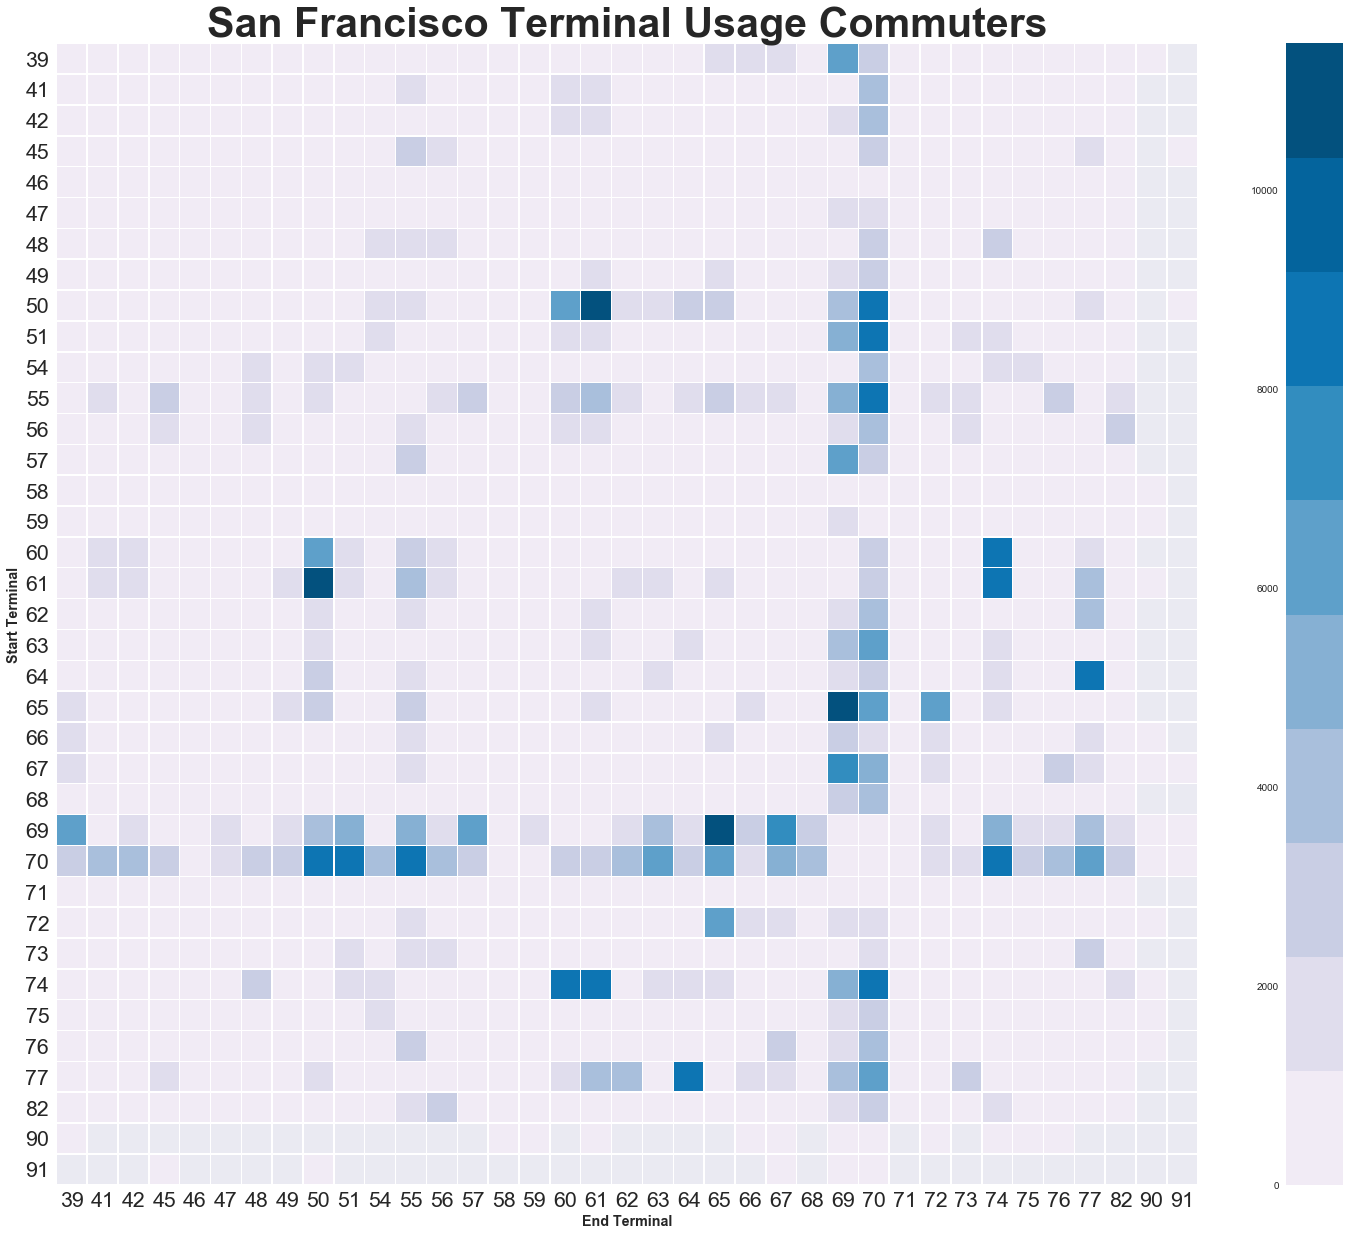

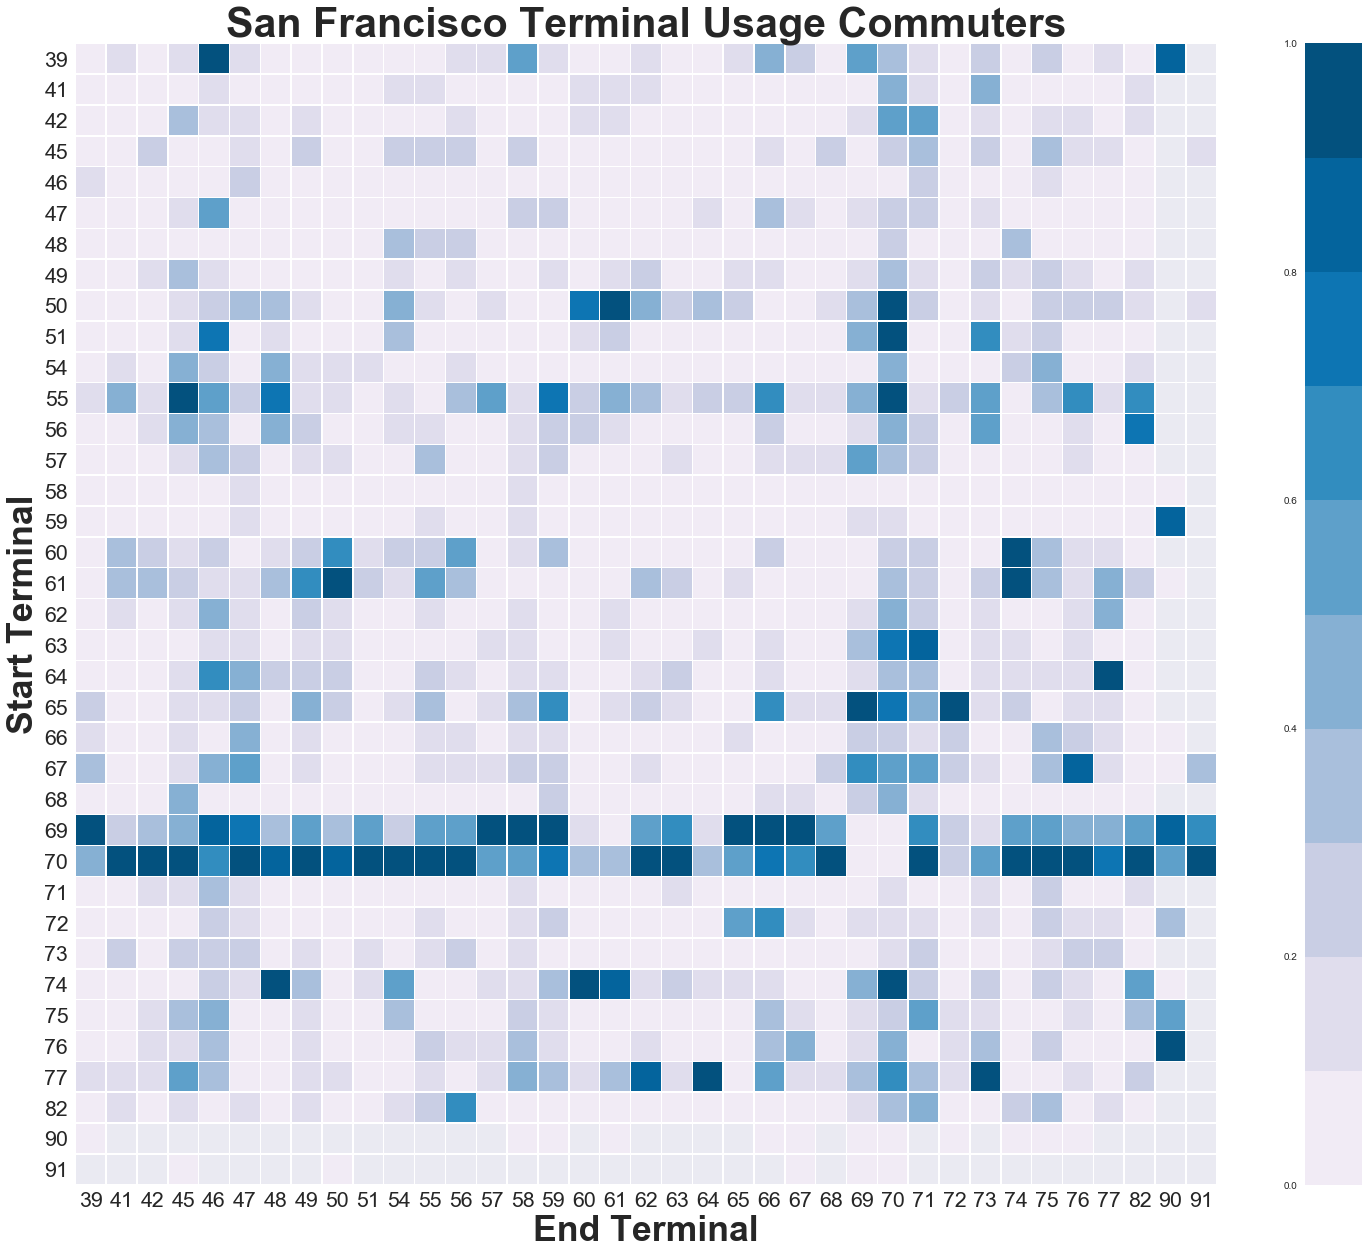

In [42]:
heatmap_regonalized_trips(commuter_data, user_type='Subscriber', title_suffix='Commuters')

## Mean Trip Duration by Hour of the Day

In [43]:
commuter_data.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,date,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,2013-08-29 00:00:00,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [44]:
duration_data = commuter_data[['start_date', 'duration']].copy()
duration_data.head(5)

,start_date,duration
0,2013-08-29 09:08:00,174
1,2013-08-29 09:24:00,1067
2,2013-08-29 09:24:00,1131
3,2013-08-29 09:24:00,1117
4,2013-08-29 09:25:00,1118


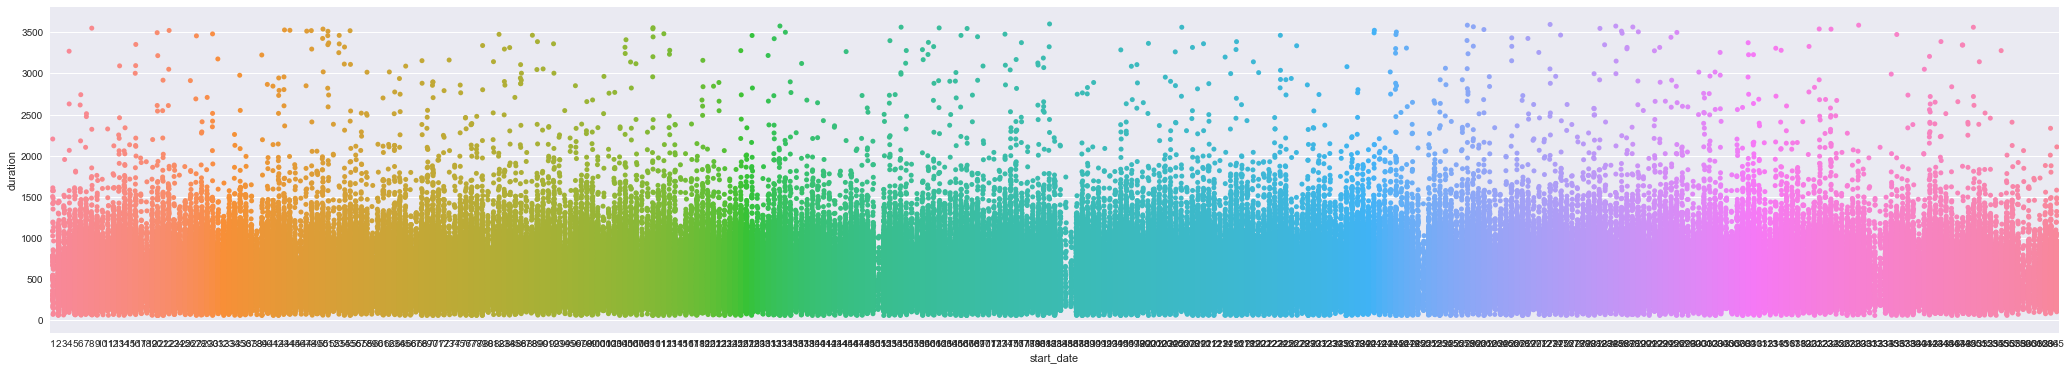

In [45]:
# plt.scatter(duration_data.start_date.dt.dayofweek, duration_data.duration, color='blue')

plt.subplots(figsize=(36,6))
ax = sns.stripplot(x=duration_data.start_date.dt.dayofyear, y=duration_data.duration, data=duration_data, jitter=True);
plt.show()

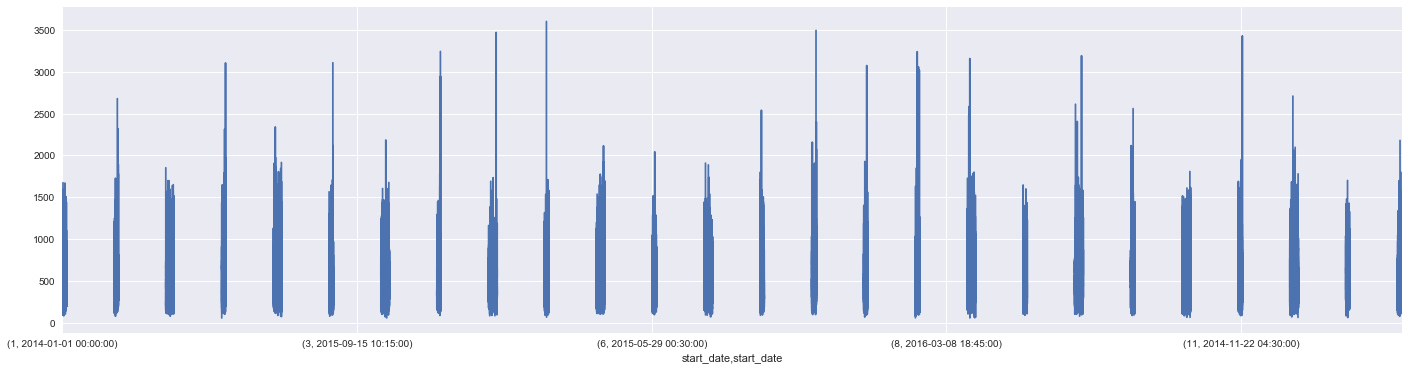

In [46]:
duration_data = subscriber_data[['start_date', 'duration']].copy()
duration_data.set_index('start_date', inplace=True)
duration_data.groupby([duration_data.index.month])['duration'].resample('15T').mean().plot(figsize=(24,6))
plt.show()

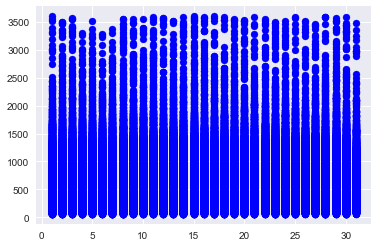

In [47]:
plt.scatter(duration_data.index.day, duration_data.duration, color='blue')
plt.show()